# TP sur les accidents routiers en France (2019-2022)

In [3]:
import pandas as pd
import numpy as np
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import os
import matplotlib.colors as colors
from matplotlib.cm import bwr as cmap
import matplotlib.patches as mpatches


In [4]:
caracteristiques = pd.read_csv('./Dataset/all_years/caracteristiques-2019-22.csv')
departements = pd.read_csv('./Dataset/departements-france.csv')
lieux = pd.read_csv('./Dataset/all_years/lieux-2019-22.csv')
usager = pd.read_csv('./Dataset/all_years/usagers-2019-22.csv')
vehicule = pd.read_csv('./Dataset/all_years/vehicules-2019-22.csv')

In [5]:
def merge_vehicle_count(caracteristiques, vehicules):
    # Compter le nombre de véhicules par "Num_Acc" dans le DataFrame vehicules
    vehicules_count = vehicules.groupby("Accident_Id")["id_vehicule"].count().reset_index().rename(columns={'id_vehicule':'Nombre_vehicule'})
    
    # Fusionner le DataFrame caracteristiques avec le DataFrame vehicules_count en utilisant la colonne "Num_Acc"
    merged_df = caracteristiques.merge(vehicules_count, on='Accident_Id')
    
    return merged_df


def merge_user_count(caracteristiques,usagers):
    # Compter le nombre d'usagers par "Accident_Id" et par sexe dans le DataFrame usagers
    usagers_count = usagers.groupby(["Accident_Id", "sexe"])["id_vehicule"].count().unstack(fill_value=0)
    usagers_count.rename(columns={1: 'Nombre_Hommes', 2: 'Nombre_Femmes'}, inplace=True)
    
    # Fusionner le DataFrame caracteristiques avec usagers_count en utilisant la colonne "Num_Acc"
    merged_df = caracteristiques.merge(usagers_count, on='Accident_Id')
    
    return merged_df

def replace_with_mapper(df, col, mapper):
    df[col] = df[col].replace(mapper)
    
    return df

# Remplacement des heures par le moment de la journée
matinee = ['06:','07:','08:','09:','10:']
journee = ['11:','12:','13:','14:','15:','16:','17:']
soiree = ['18:','19:','20:','21:','22:','23:']
nuit = ['00:','01:','02:','03:','04:','05:']

def replace_hour(hour):
    hour = hour[:3]
    if hour in matinee:
        return 'Matinée'
    elif hour in journee:
        return 'Journée'
    elif hour in soiree:
        return 'Soirée'
    elif hour in nuit:
        return 'Nuit'
    else:
        'Lucas'

In [6]:
years = ['19', '20', '21', '22']
files_name = ["caracteristiques-20", "lieux-20", "usagers-20", "vehicules-20"]
if not os.path.exists('./Dataset/all_years'):
    os.mkdir('./Dataset/all_years/', 0o666) 
for file_name in files_name:
    result = []
    for year in years:
        file_path = f'./Dataset/{year}/{file_name}{year}.csv'
        sep = ';'
        df = pd.read_csv(file_path, sep=sep, low_memory=False)
        # if 'id_usager' in df.columns:
        #     df = df.drop(columns=['id_usager'])
        result.append(df)
    combined_df = pd.concat(result, ignore_index=True)
    combined_df.to_csv(f'./Dataset/all_years/{file_name}{years[0]}-{years[-1]}.csv', index=False)

In [7]:
caracteristiques = caracteristiques.drop(['com', 'adr', 'lat', 'long'], axis=1)

# Remplacer les numéros des mois par leurs noms
caracteristiques.mois = caracteristiques.mois.map({
    1:'Janvier',
    2:'Février',
    3:'Mars',
    4:'Avril',
    5:'Mai',
    6:'Juin',
    7:'Juillet',
    8:'Août',
    9:'Septembre',
    10:'Octobre',
    11:'Novembre',
    12:'Décembre'
}, na_action=None)

caracteristiques.hrmn = caracteristiques.hrmn.apply(replace_hour)

caracteristiques = replace_with_mapper(caracteristiques, 'lum', {
    1 : 'Plein jour',
    2 : 'Crépuscule ou aube',
    3 : 'Nuit sans éclairage public',
    4 : 'Nuit avec éclairage public non allumé',
    5 : 'Nuit avec éclairage public allumé'
})

# Remplacer les numéros de départements par leur noms
departements_mapper = departements.set_index('code_departement')['nom_departement'].to_dict()
caracteristiques = replace_with_mapper(caracteristiques, 'dep', departements_mapper)

caracteristiques = replace_with_mapper(caracteristiques, 'agg', {
    1 : 'Hors agglomération',
    2 : 'En agglomération'
})
caracteristiques = replace_with_mapper(caracteristiques, 'int', {
    1 : 'Hors intersection',
    2 : 'Intersection en X',
    3 : 'Intersection en T',
    4 : 'Intersection en Y',
    5 : 'Intersection à plus de 4 branches',
    6 : 'Giratoire',
    7 : 'Place',
    8 : 'Passage à niveau',
    9 : 'Autre intersection'
})
caracteristiques = replace_with_mapper(caracteristiques, 'atm', {
    -1 :'Non renseigné',
    1 : 'Normale',
    2 : 'Pluie légère',
    3 : 'Pluie forte',
    4 : 'Neige - grêle',
    5 : 'Brouillard - fumée',
    6 : 'Vent fort - tempête',
    7 : 'Temps éblouissant',
    8 : 'Temps couvert',
    9 : 'Autre'
})
caracteristiques = replace_with_mapper(caracteristiques, 'col', {
    -1 :'Non renseigné',
    1 : 'Deux véhicules - frontale',
    2 : 'Deux véhicules – par l’arrière',
    3 : 'Deux véhicules – par le coté',
    4 : 'Trois véhicules et plus – en chaîne',
    5 : 'Trois véhicules et plus - collisions multiples',
    6 : 'Autre collision',
    7 : 'Sans collision'
})

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'catr']], 'catr', {
    1:'Autoroute',
    2:'Route nationale',
    3:'Route Départementale',
    4:'Voie Communales',
    5:'Hors réseau public',
    6:'Parc de stationnementouvert à la circulation publique',
    7:'Routes de métropole urbaine',
    9:'autre'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'circ']], 'circ', {
    -1:'Non renseigné',
    1:'A sens unique',
    2:'Bidirectionnelle',
    3:'A chaussées séparées',
    4:'Avec voies d’affectation variable'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(lieux.loc[:, ['Accident_Id', 'nbv']], on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'surf']], 'surf', {
    -1:'Non renseigné',
    1:'Normale',
    2:'Mouillée',
    3:'Flaques',
    4:'Inondée',
    5:'Enneigée',
    6:'Boue',
    7:'Verglacée',
    8:'Corps gras – huile',
    9:'Autre'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'infra']], 'infra', {
    -1:'Non renseigné',
    0:'Aucun',
    1:'Souterrain -tunnel',
    2:'Pont -autopont',
    3:'Bretelle d’échangeur ou de raccordement',
    4:'Voie ferrée',
    5:'Carrefour aménagé',
    6:'Zone piétonne',
    7:'Zone de péage',
    8:'Chantier',
    9:'Autres'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(
replace_with_mapper(lieux.loc[:, ['Accident_Id', 'situ']], 'situ', {
    -1:'Non renseigné',
    0:'Aucun',
    1:'Sur chaussée',
    2:'Sur bande d’arrêt d’urgence',
    3:'Sur accotement',
    4:'Sur trottoir',
    5:'Sur piste cyclable',
    6:'Sur autre voie spéciale',
    8:'Autres'
}), on='Accident_Id', how='left')

caracteristiques = caracteristiques.merge(lieux.loc[:, ['Accident_Id', 'vma']], on='Accident_Id', how='left')

caracteristiques.rename(columns={
    'an': 'année',
	'hrmn': 'horraire',
    'lum': 'luminosité',
    'dep': 'département',
    'agg': 'agglomération',
    'int': 'intersection',
    'atm': 'atmosphere',
    'col': 'collision',
    'catr': 'catégorie de route',
    'circ': 'régime de circulation',
    'nbv': 'nombre de voix',
    'surf': 'etat de la surface',
    'infra': 'infrastructure',
    'situ': 'situation',
    'vma': 'vitesse max autorisée'
}, inplace=True)

caracteristiques.head(5)

,Accident_Id,jour,mois,année,horraire,luminosité,département,agglomération,intersection,atmosphere,collision,catégorie de route,régime de circulation,nombre de voix,etat de la surface,infrastructure,situation,vitesse max autorisée
0,201900000001,30,Novembre,2019,Nuit,Nuit avec éclairage public non allumé,Seine-Saint-Denis,Hors agglomération,Hors intersection,Normale,Deux véhicules – par l’arrière,Autoroute,A chaussées séparées,10,Normale,Pont -autopont,Sur chaussée,70
1,201900000002,30,Novembre,2019,Nuit,Nuit sans éclairage public,Seine-Saint-Denis,Hors agglomération,Hors intersection,Normale,Autre collision,Autoroute,A sens unique,2,Normale,Aucun,Sur chaussée,70
2,201900000003,28,Novembre,2019,Journée,Plein jour,Hauts-de-Seine,Hors agglomération,Hors intersection,Normale,Trois véhicules et plus – en chaîne,Autoroute,A chaussées séparées,8,Normale,Aucun,Sur chaussée,90
3,201900000004,30,Novembre,2019,Soirée,Nuit avec éclairage public allumé,Val-de-Marne,Hors agglomération,Hors intersection,Normale,Trois véhicules et plus – en chaîne,Autoroute,A chaussées séparées,5,Normale,Aucun,Sur chaussée,90
4,201900000005,30,Novembre,2019,Nuit,Nuit sans éclairage public,Val-de-Marne,Hors agglomération,Hors intersection,Normale,Deux véhicules – par l’arrière,Autoroute,A sens unique,3,Normale,Pont -autopont,Sur chaussée,90


In [8]:
vehicule['catv'] = vehicule['catv'].replace([0, 99, -1],  ['indéterminable', 'autre véhicule', 'indéterminé'])
vehicule['catv'] = vehicule['catv'].replace([10, 13, 14, 15, 16, 17, 20, 21, 37, 38, 39, 40], 'vehicules lourd')
vehicule['catv'] = vehicule['catv'].replace([3, 7, 35, 36, 50, 60], 'vehicules leger')
vehicule['catv'] = vehicule['catv'].replace([1, 2, 30, 31, 32, 33, 34, 41, 42, 43, 80], 'vehicules deux roues')

r = vehicule.groupby('Accident_Id')['catv'].value_counts().unstack().fillna(0)
r.reset_index(inplace=True)
r[['indéterminable', 'autre véhicule', 'indéterminé', 'vehicules lourd', 'vehicules leger', 'vehicules deux roues']] = r[['indéterminable', 'autre véhicule', 'indéterminé', 'vehicules lourd', 'vehicules leger', 'vehicules deux roues']].astype(int)
caracteristiques = caracteristiques.merge(r, on='Accident_Id', how='left')

caracteristiques.head(5)


r = usager.groupby('Accident_Id')['grav'].value_counts().unstack().fillna(0)
r.reset_index(inplace=True)
r.rename(columns={
    -1:'gravité indéterminé',
    1:'indemne',
    2:'tué',
    3:'blessé hospitalisé',
    4:'blessé léger'
}, inplace=True)
r[['gravité indéterminé', 'indemne', 'tué', 'blessé hospitalisé', 'blessé léger']] = r[['gravité indéterminé', 'indemne', 'tué', 'blessé hospitalisé', 'blessé léger']].astype(int)

caracteristiques = caracteristiques.merge(r, on='Accident_Id', how='left')

r = usager.groupby('Accident_Id')['sexe'].value_counts().unstack().fillna(0)
r.reset_index(inplace=True)
r.rename(columns={
    -1:'autre',
    1:'hommes',
    2:'femmes'
}, inplace=True)
r[['autre', 'hommes', 'femmes']] = r[['autre', 'hommes', 'femmes']].astype(int)

caracteristiques = caracteristiques.merge(r, on='Accident_Id', how='left')

usager['année'] = usager['Accident_Id'].map(caracteristiques.set_index('Accident_Id')['année'])
usager['age_category'] = pd.cut(
    usager['année'] - usager['an_nais'],
    bins=[0, 18, 59, float('inf')],
    labels=["jeune", "adulte", "senior"],
    right=True
)

number_of_people = usager.groupby(by='Accident_Id')['age_category'].value_counts().unstack().fillna(0)
number_of_people.reset_index(inplace=True)

caracteristiques = caracteristiques.merge(number_of_people, on='Accident_Id', how='right')

# Clean
usager.drop(columns=['année'])
usager.drop(columns=['age_category'])

r = usager.groupby('Accident_Id')['catu'].value_counts().unstack().fillna(0)
r.reset_index(inplace=True)
r.rename(columns={
    1:'conducteur',
    2:'passager',
    3:'piéton'
}, inplace=True)
r[['conducteur', 'passager', 'piéton']] = r[['conducteur', 'passager', 'piéton']].astype(int)
caracteristiques = caracteristiques.merge(r, on='Accident_Id', how='left')

display(caracteristiques.info())
caracteristiques.sort_values(by="département").head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218404 entries, 0 to 218403
Data columns (total 38 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Accident_Id             218404 non-null  int64 
 1   jour                    218404 non-null  int64 
 2   mois                    218404 non-null  object
 3   année                   218404 non-null  int64 
 4   horraire                218404 non-null  object
 5   luminosité              218404 non-null  object
 6   département             218404 non-null  object
 7   agglomération           218404 non-null  object
 8   intersection            218404 non-null  object
 9   atmosphere              218404 non-null  object
 10  collision               218404 non-null  object
 11  catégorie de route      218404 non-null  object
 12  régime de circulation   218404 non-null  object
 13  nombre de voix          218404 non-null  object
 14  etat de la surface      218404 non-n

None

,Accident_Id,jour,mois,année,horraire,luminosité,département,agglomération,intersection,atmosphere,...,blessé léger,autre,hommes,femmes,jeune,adulte,senior,conducteur,passager,piéton
192169,202200029068,31,Août,2022,Journée,Plein jour,Ain,En agglomération,Hors intersection,Normale,...,1,0,1,0,0,1,0,1,0,0
113467,202100006884,12,Novembre,2021,Journée,Nuit sans éclairage public,Ain,Hors agglomération,Hors intersection,Normale,...,1,0,2,2,0,3,1,2,2,0
73064,202000014225,25,Décembre,2020,Matinée,Plein jour,Ain,Hors agglomération,Intersection en T,Temps couvert,...,0,0,1,0,0,0,1,1,0,0
101629,202000042790,25,Juillet,2020,Journée,Plein jour,Ain,Hors agglomération,Hors intersection,Normale,...,0,0,3,0,0,2,1,3,0,0
136696,202100030113,9,Juillet,2021,Journée,Plein jour,Ain,En agglomération,Intersection en T,Normale,...,1,0,2,0,0,1,1,2,0,0
136695,202100030112,8,Juillet,2021,Matinée,Plein jour,Ain,En agglomération,Hors intersection,Normale,...,1,0,2,0,0,1,1,1,0,1
163619,202200000518,21,Octobre,2022,Matinée,Plein jour,Ain,En agglomération,Intersection en T,Pluie légère,...,0,0,0,2,0,1,1,2,0,0


In [9]:
columns_name = caracteristiques.iloc[:,17:].columns

## Normalisation des données

In [10]:
from sklearn.preprocessing import StandardScaler

## Analyse en composantes principales

In [11]:
from sklearn.decomposition import PCA

In [12]:


def print_top_comp(components, feature_names, n_top_comp):
    seuil=1/np.sqrt(len(feature_names))-0.02
    count = 0
    fig, ax = plt.subplots(2,2,figsize = (17,17))
    for comp_idx, topic in enumerate(components):
        feature_pos=feature_names[topic>=seuil]
        feature_neg=feature_names[topic<-seuil]
        n_top_comp_pos=min(n_top_comp,feature_pos.shape[0])
        n_top_comp_neg=min(n_top_comp,feature_neg.shape[0])
        feature_pos=feature_names[topic.argsort()[::-1][:n_top_comp_pos]]
        feature_neg=feature_names[topic.argsort()[:n_top_comp_neg]]
        fea=np.concatenate((feature_pos,feature_neg))
        com_pos=np.sort(topic)[::-1][:n_top_comp_pos]
        com_neg=np.sort(topic)[:n_top_comp_neg]
        com=np.concatenate((com_pos,com_neg))
                
        c_normal = colors.PowerNorm(1,vmin=min(com),vmax=max(com))
        _COLORS = cmap(c_normal(com))
                       
        components = pd.DataFrame(np.array(com),index =fea) 

        # Plot the feature weights as a function of the components
        components.plot(ax = ax[0,count], kind = 'bar',align = "center", color=_COLORS)
        #plt.xlabel("Dimension #%d " % comp_idx)
        ax[0,count].set_ylabel("Feature Weights") 
        red_patch = mpatches.Patch(color='red', label="Composante-%d " % (comp_idx+1))
        ax[0,count].legend(handles=[red_patch])
        
        ax[0,count].tick_params(axis='both', which='both', labelsize=8)
        ax[0,count].set_xticklabels(ax[0,count].get_xticklabels(), rotation=60)
        count += 1
    return fig , ax

In [13]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import colors as clr
from scipy.cluster.hierarchy import dendrogram, linkage
import operator
import matplotlib

def visualize_data(name):
    columns_name = caracteristiques.iloc[:,17:].columns
    newDfCarac = caracteristiques.groupby([name])[columns_name].mean()
    Xcarac=newDfCarac.iloc[:,0:].values
    label_carac=newDfCarac.index
    SS=StandardScaler()
    SS.fit(Xcarac)
    Xcarac_ss=SS.transform(Xcarac)
    pca=PCA(n_components=2)
    pca.fit(Xcarac_ss)
    Xcarac_pca=pca.transform(Xcarac_ss)
    fig ,ax = print_top_comp(pca.components_[:2,:], newDfCarac.columns, len(newDfCarac.columns))
    coef = np.transpose(pca.components_)
    cols = ['y'+str(x+1) for x in range(2)]
    pc_infos = pd.DataFrame(coef, columns=cols, index=newDfCarac.iloc[:,0:].columns)
    plt.Circle((0,0),radius=10, color='g', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
    # Ajouter les axes et donner la limite pour chaque axe
    ax_cercle = fig.add_subplot(2, 2, 3)
    ax_cercle.set_xticks([])
    ax_cercle.set_yticks([])
    # Ajouter les axes et donner la limite pour chaque axe
    ax_cercle.set_xlim(-1, 1)
    ax_cercle.set_ylim(-1, 1)
    circle1 = plt.Circle((0, 0), radius=1, color='g', fill=False)
    ax_cercle.add_artist(circle1)

    # Affichage de chaque variable explicative dans le cercle
    for idx in range(len(pc_infos["y1"])):
        x = pc_infos["y1"][idx]
        y = pc_infos["y2"][idx]
        ax_cercle.plot([0.0, x], [0.0, y], 'k-')
        ax_cercle.plot(x, y, 'rx')
        ax_cercle.annotate(pc_infos.index[idx], xy=(x, y))

    ax_cercle.set_xlim((-1, 1))
    ax_cercle.set_ylim((-1, 1))
    ax_cercle.set_title("Circle of Correlations")

    ax[1,1].scatter(Xcarac_pca[:, 0], Xcarac_pca[:, 1])
    for label, x, y in zip(label_carac, Xcarac_pca[:, 0], Xcarac_pca[:, 1]):
        ax[1,1].annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
        
    plt.show()
    
    # KMeans
    testArrKMeans = ['complete','single','ward','average']
    for i in range(len(testArrKMeans)) :
        Z = linkage(Xcarac_ss, testArrKMeans[i])
        plt.figure(figsize=(25,10))
        plt.title('Hierarchical Clustering Dendrogram with ' + testArrKMeans[i])
        plt.xlabel('sample index')
        plt.ylabel('distance')
        dendrogram(
            Z,
            leaf_rotation=90,    # rotates the x axis labels
            leaf_font_size=8.,   # font size for the x axis labels
        )
        plt.show()
    
    bestScore = { }
    
    for i in np.arange(2,len(label_carac)):
        km = KMeans(n_clusters=i, random_state=1)
        km.fit(Xcarac_ss)
        clustering_kmeans = km.labels_
        score_s = silhouette_score(Xcarac_ss, clustering_kmeans, metric='euclidean')
        #print('Silhouette score pour {0:d} clusters vaut {1:.3f}'.format(i,score_s))
        bestScore[i] = score_s
    
    number_cluster = max(bestScore.items(), key=operator.itemgetter(1))
    print('Le meilleur nombre de cluster est {0:d}'.format(number_cluster[0]))
    
    km = KMeans(n_clusters=number_cluster[0], random_state=1)
    km.fit(Xcarac_ss)
    clustering_kmeans=km.labels_
    colors = ['red','yellow','blue','pink','black']
    plt.scatter(Xcarac_pca[:,0], Xcarac_pca[:,1], c= clustering_kmeans, cmap=clr.ListedColormap(colors))
    for label, x, y in zip(label_carac, Xcarac_pca[:,0], Xcarac_pca[:,1]):
        plt.annotate(label,xy=(x,y), xytext=(-0.2,0.2), textcoords='offset points')
    plt.show()
    
    # CAH
    
    testArrCAH = ['ward','average']
    for j in range(len(testArrCAH)):
        print(f"La méthode utilisé pour le CAH est {testArrCAH[j]}")
        for i in range(2,len(label_carac)):
            cah = AgglomerativeClustering(linkage=testArrCAH[j], n_clusters=i) 
            cah.fit(Xcarac_ss)
            clustering_cah = cah.labels_
            score_s = silhouette_score(Xcarac_ss, clustering_cah, metric ='euclidean')
            #print("la silhouette score pour {0:d} clusters vaut {1:.3f}".format(i,score_s))

        number_cluster = max(bestScore.items(), key=operator.itemgetter(1))
        print('Le meilleur nombre de cluster est {0:d}'.format(number_cluster[0]))

        cah = AgglomerativeClustering(linkage=testArrCAH[j], n_clusters=number_cluster[0]) 
        cah.fit(Xcarac_ss)
        clustering_cah = cah.labels_
        plt.scatter(Xcarac_pca[:, 0], Xcarac_pca[:, 1], c=clustering_cah, cmap=matplotlib.colors.ListedColormap(colors))
        for label, x, y in zip(label_carac, Xcarac_pca[:, 0], Xcarac_pca[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
        plt.show()
    

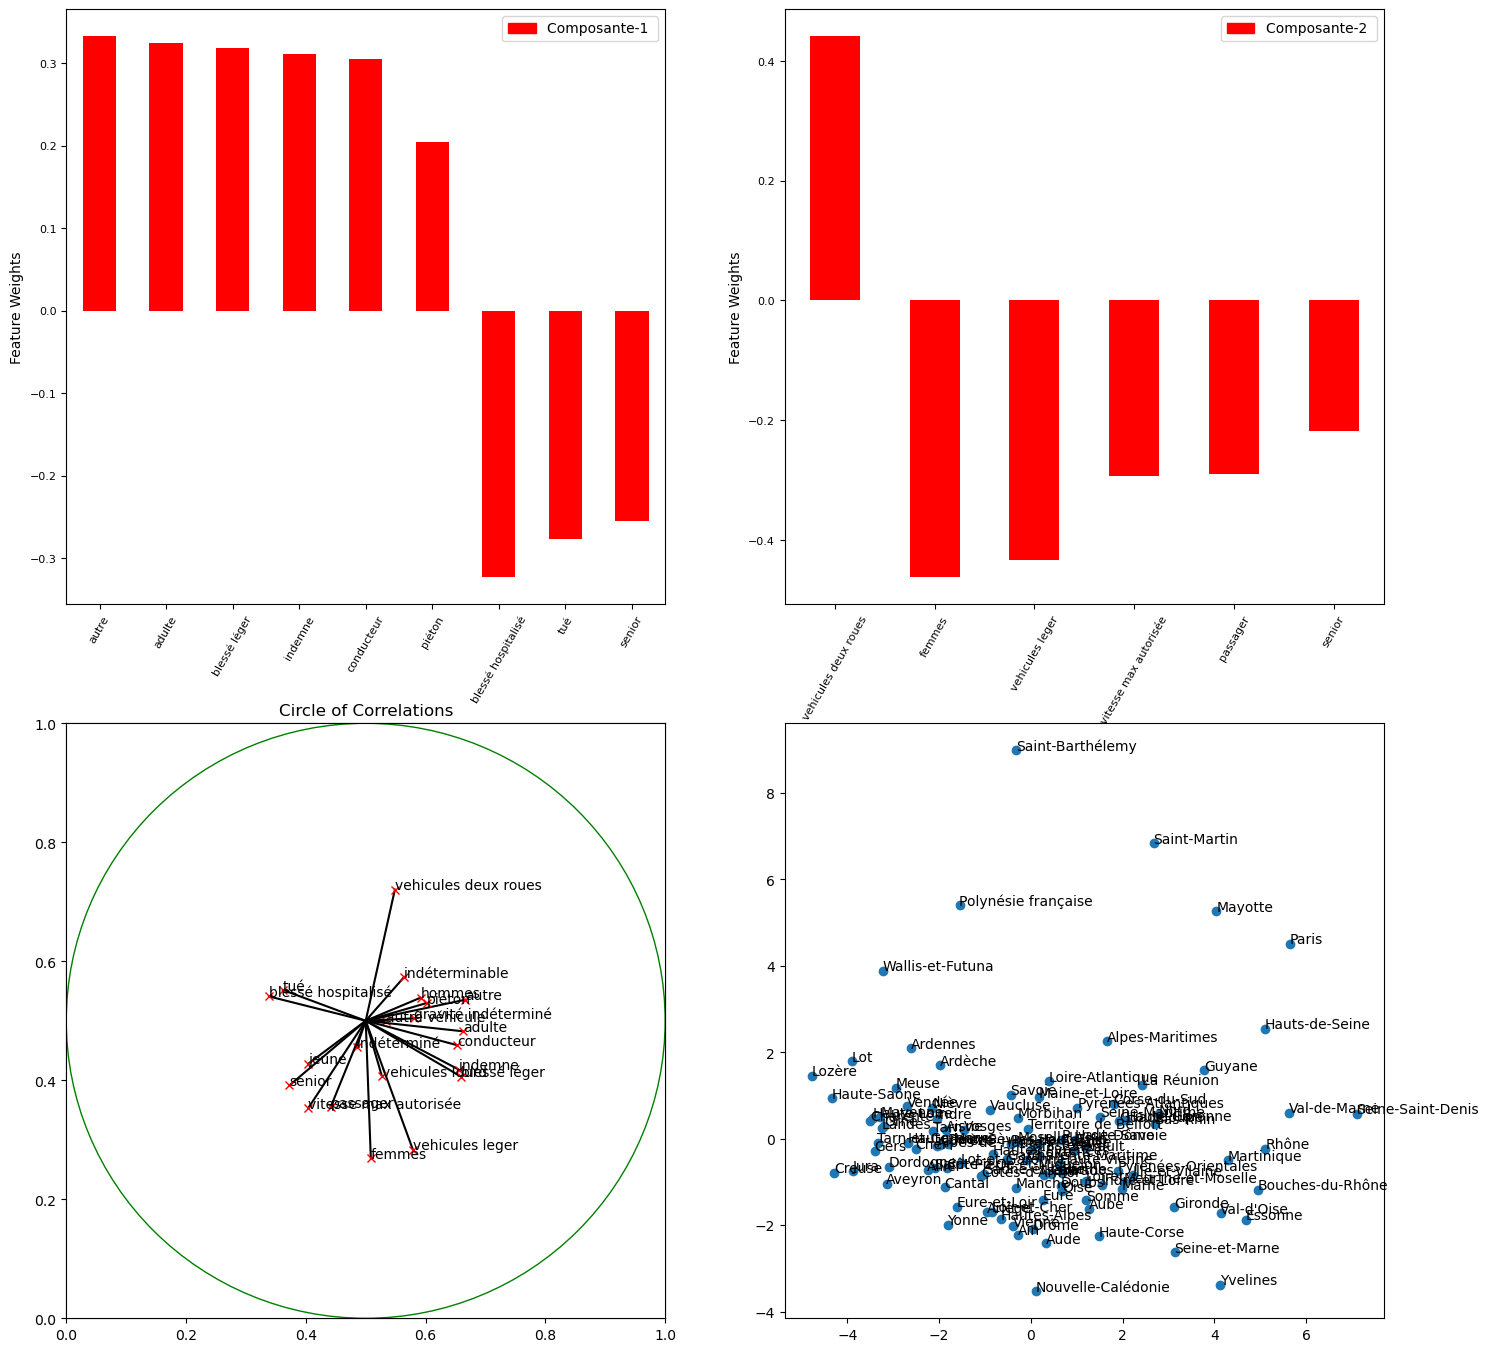

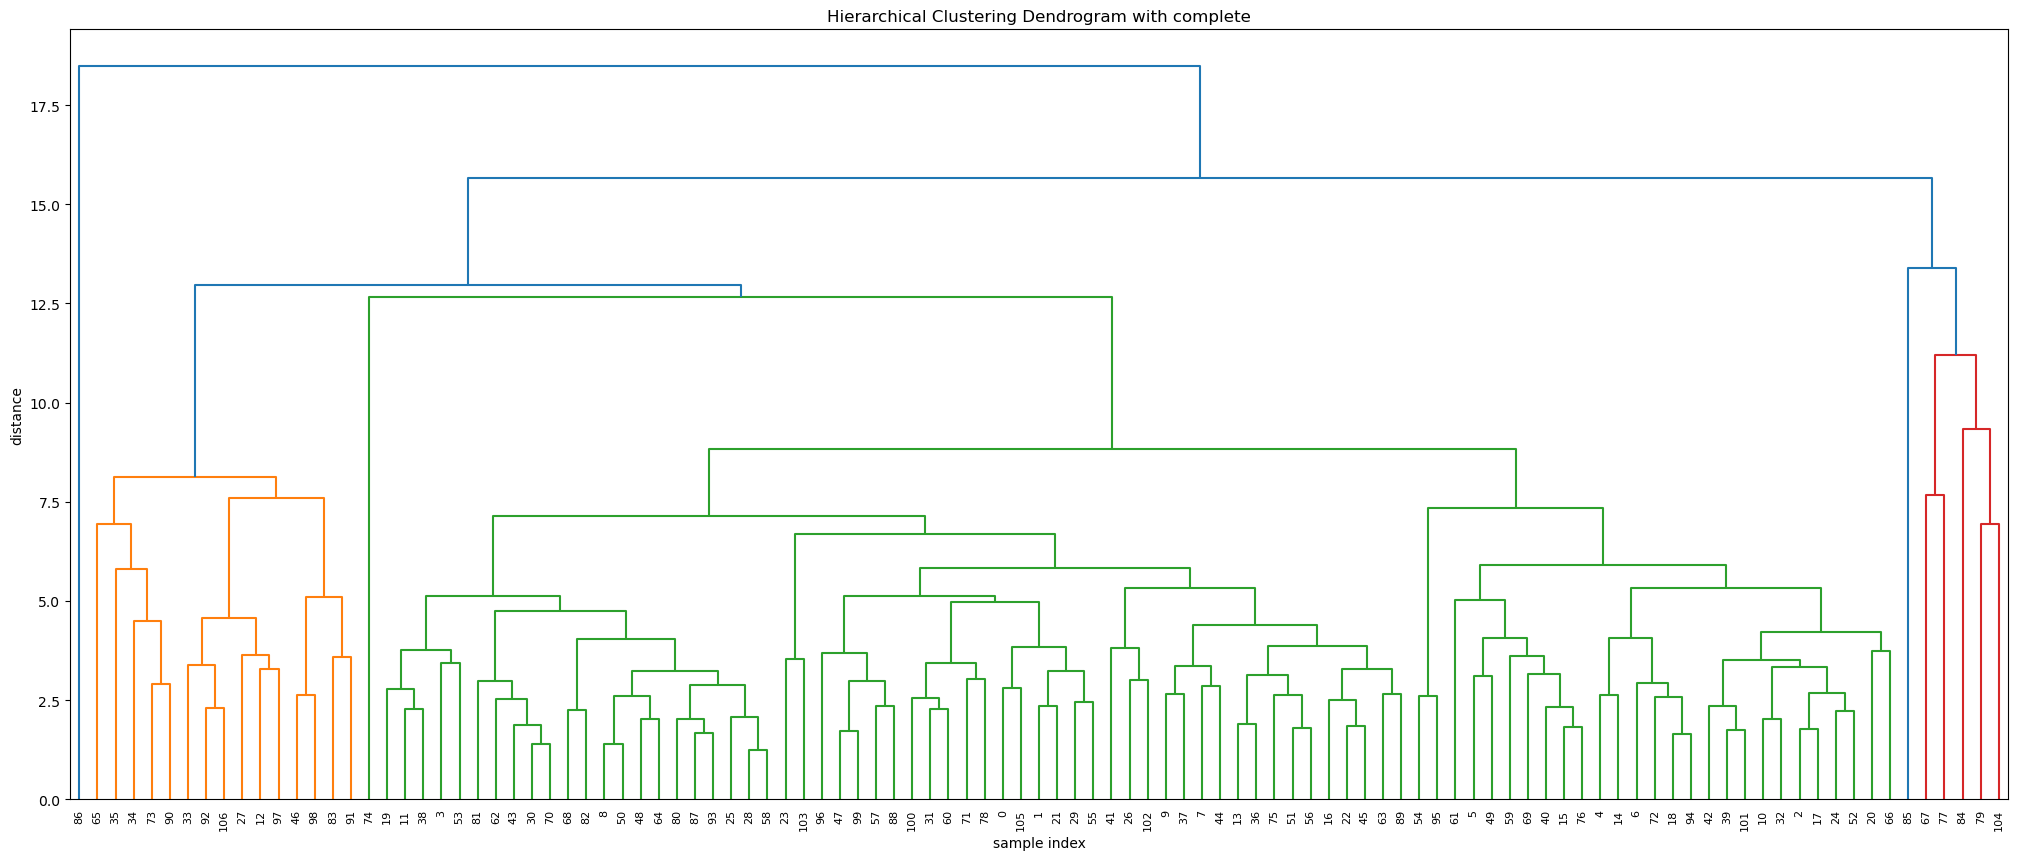

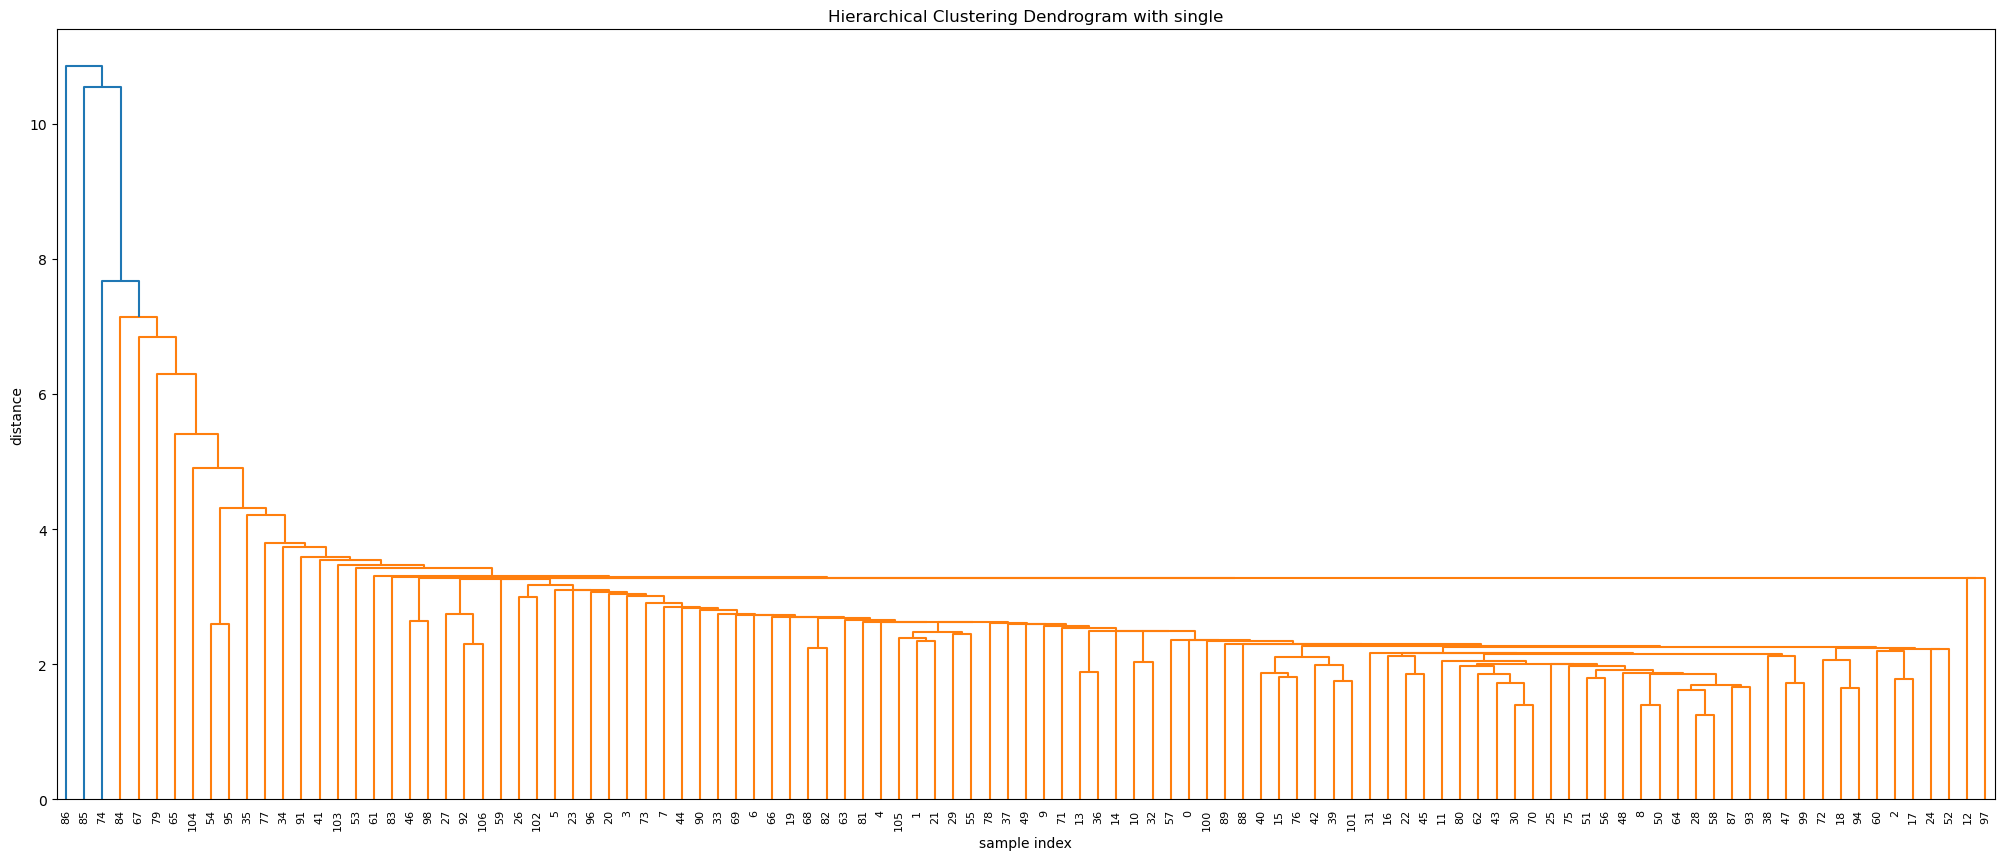

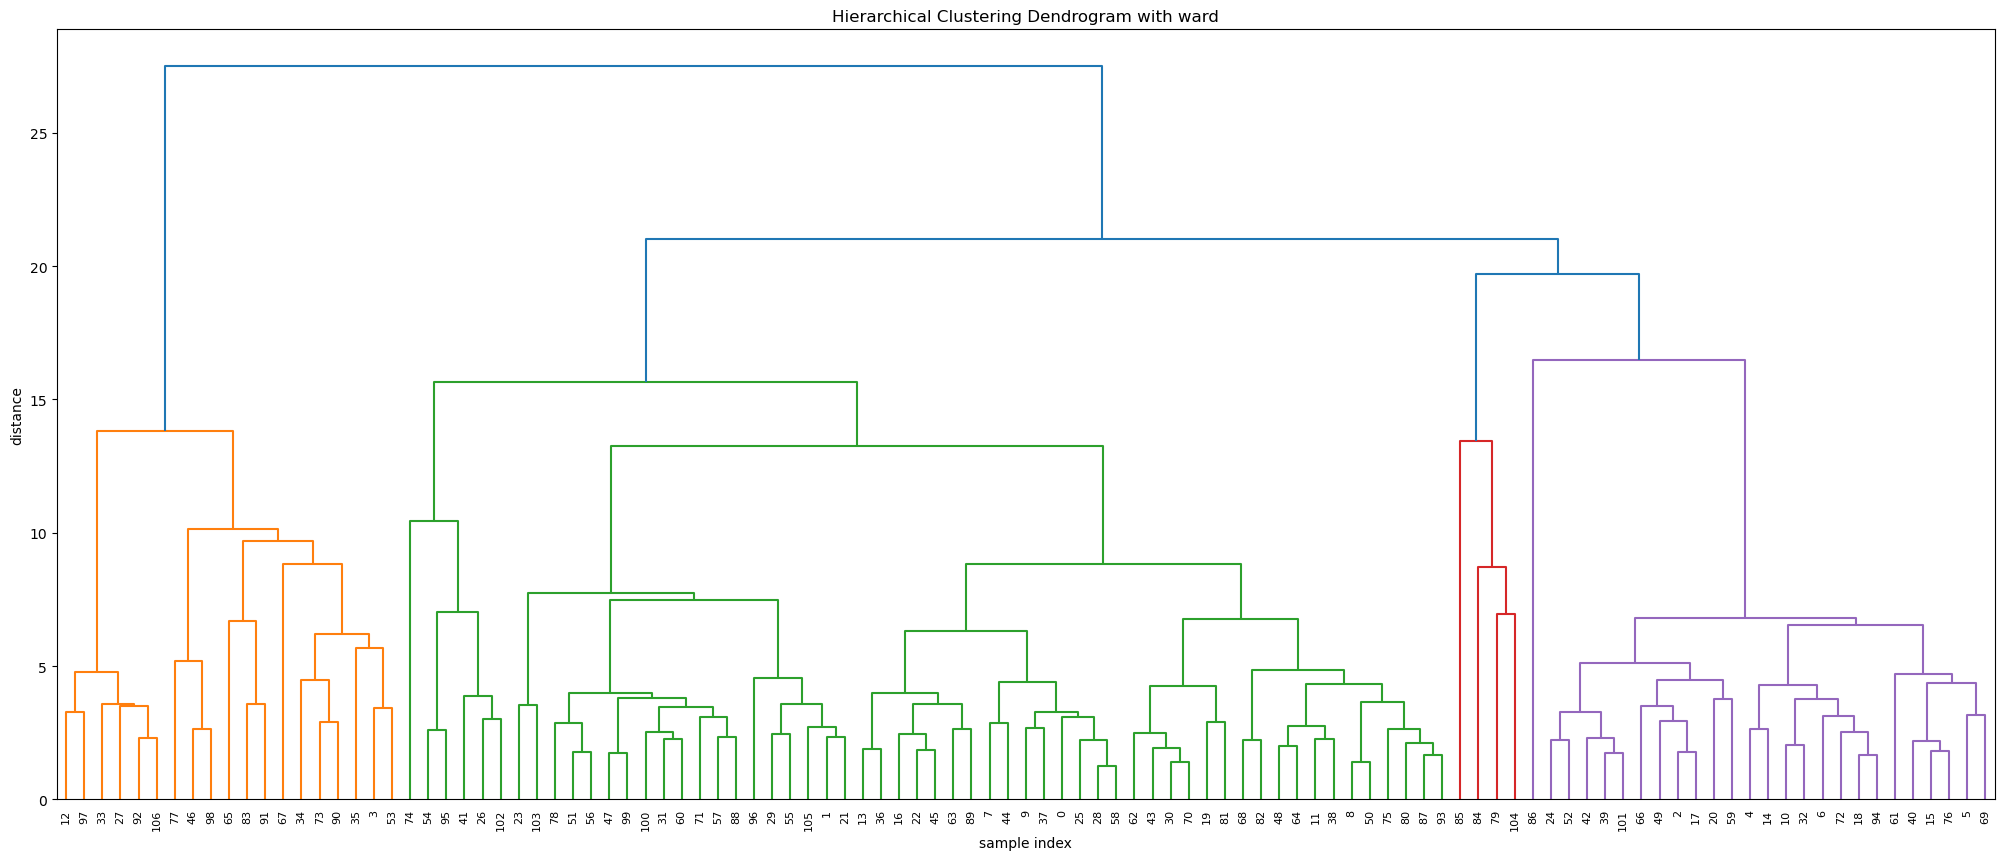

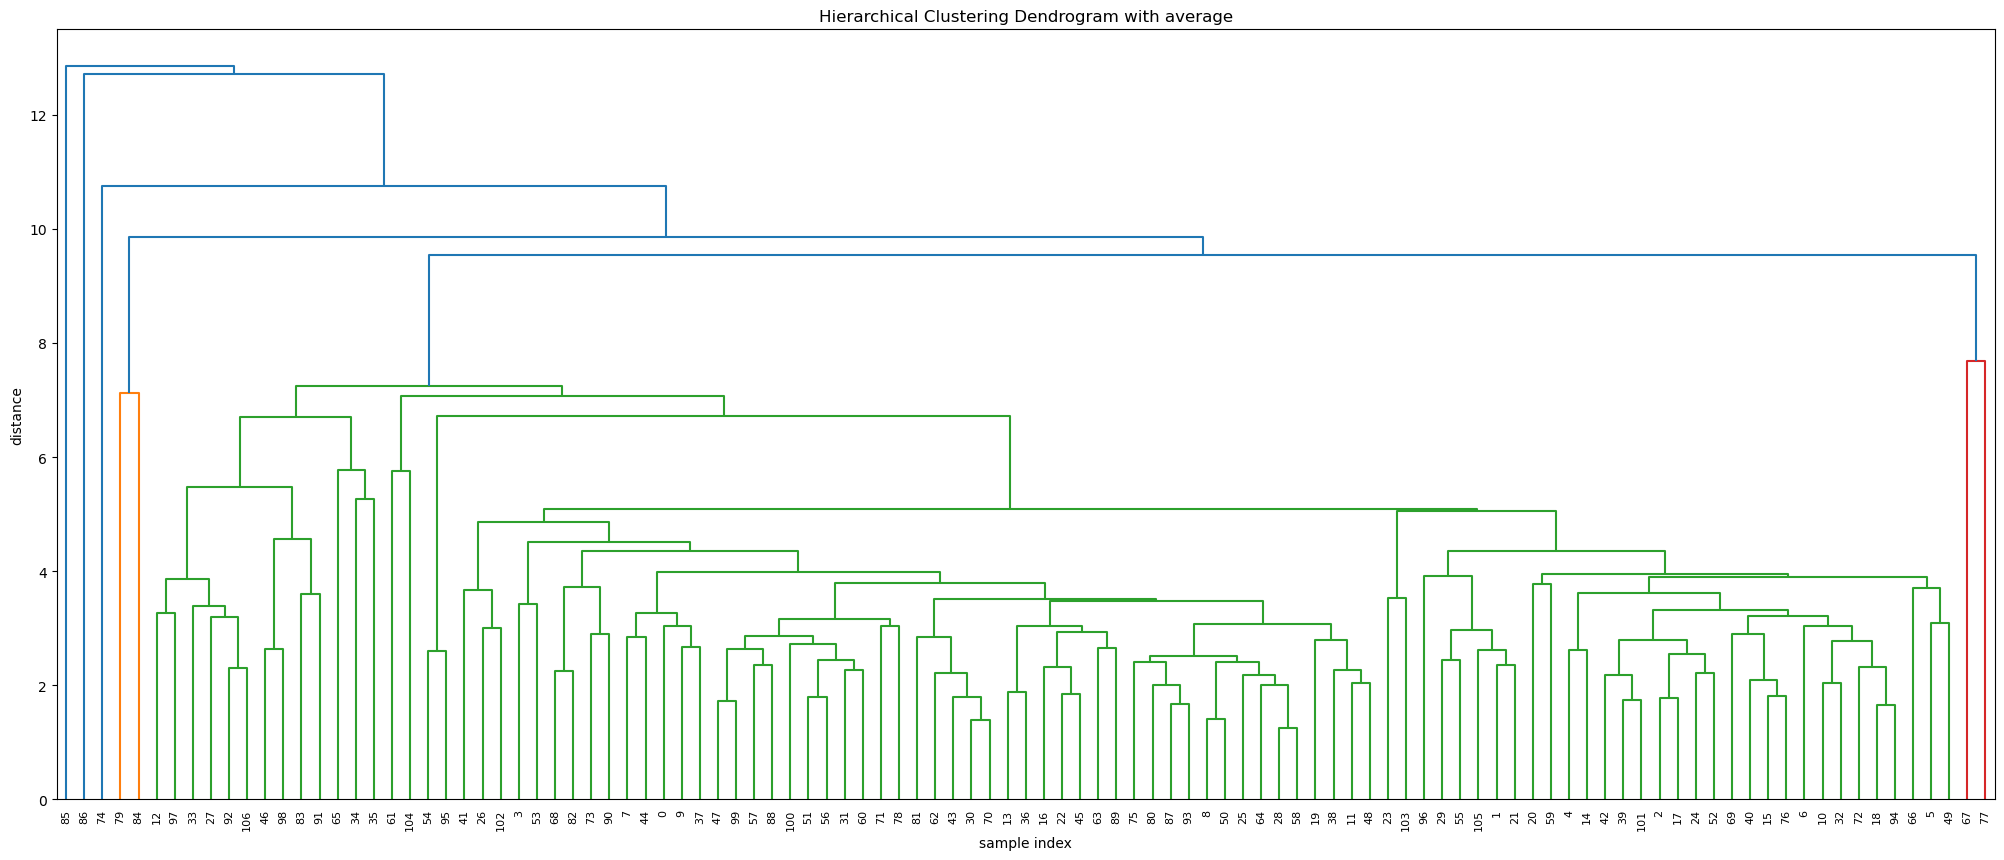

Le meilleur nombre de cluster est 2


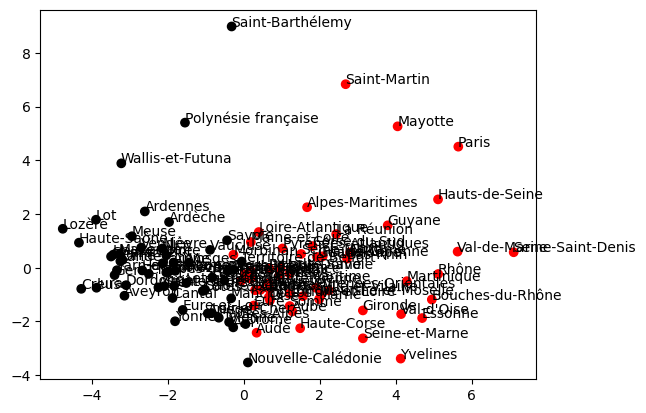

La méthode utilisé pour le CAH est ward
Le meilleur nombre de cluster est 2


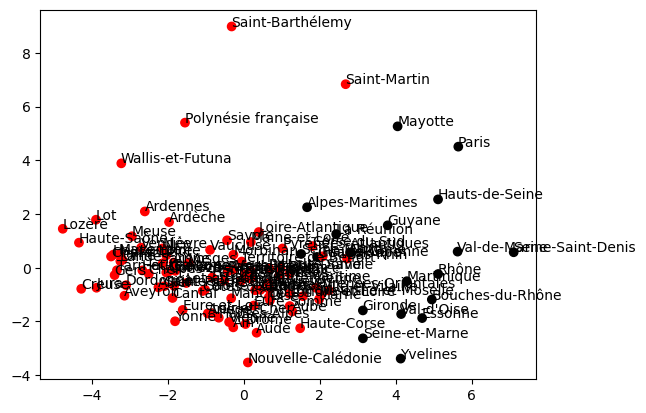

La méthode utilisé pour le CAH est average
Le meilleur nombre de cluster est 2


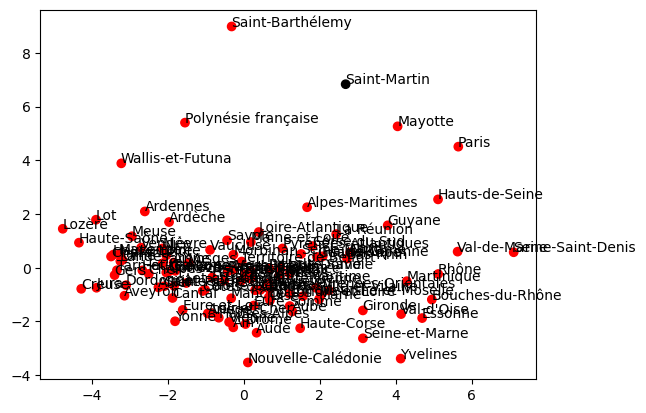

In [14]:
visualize_data("département")

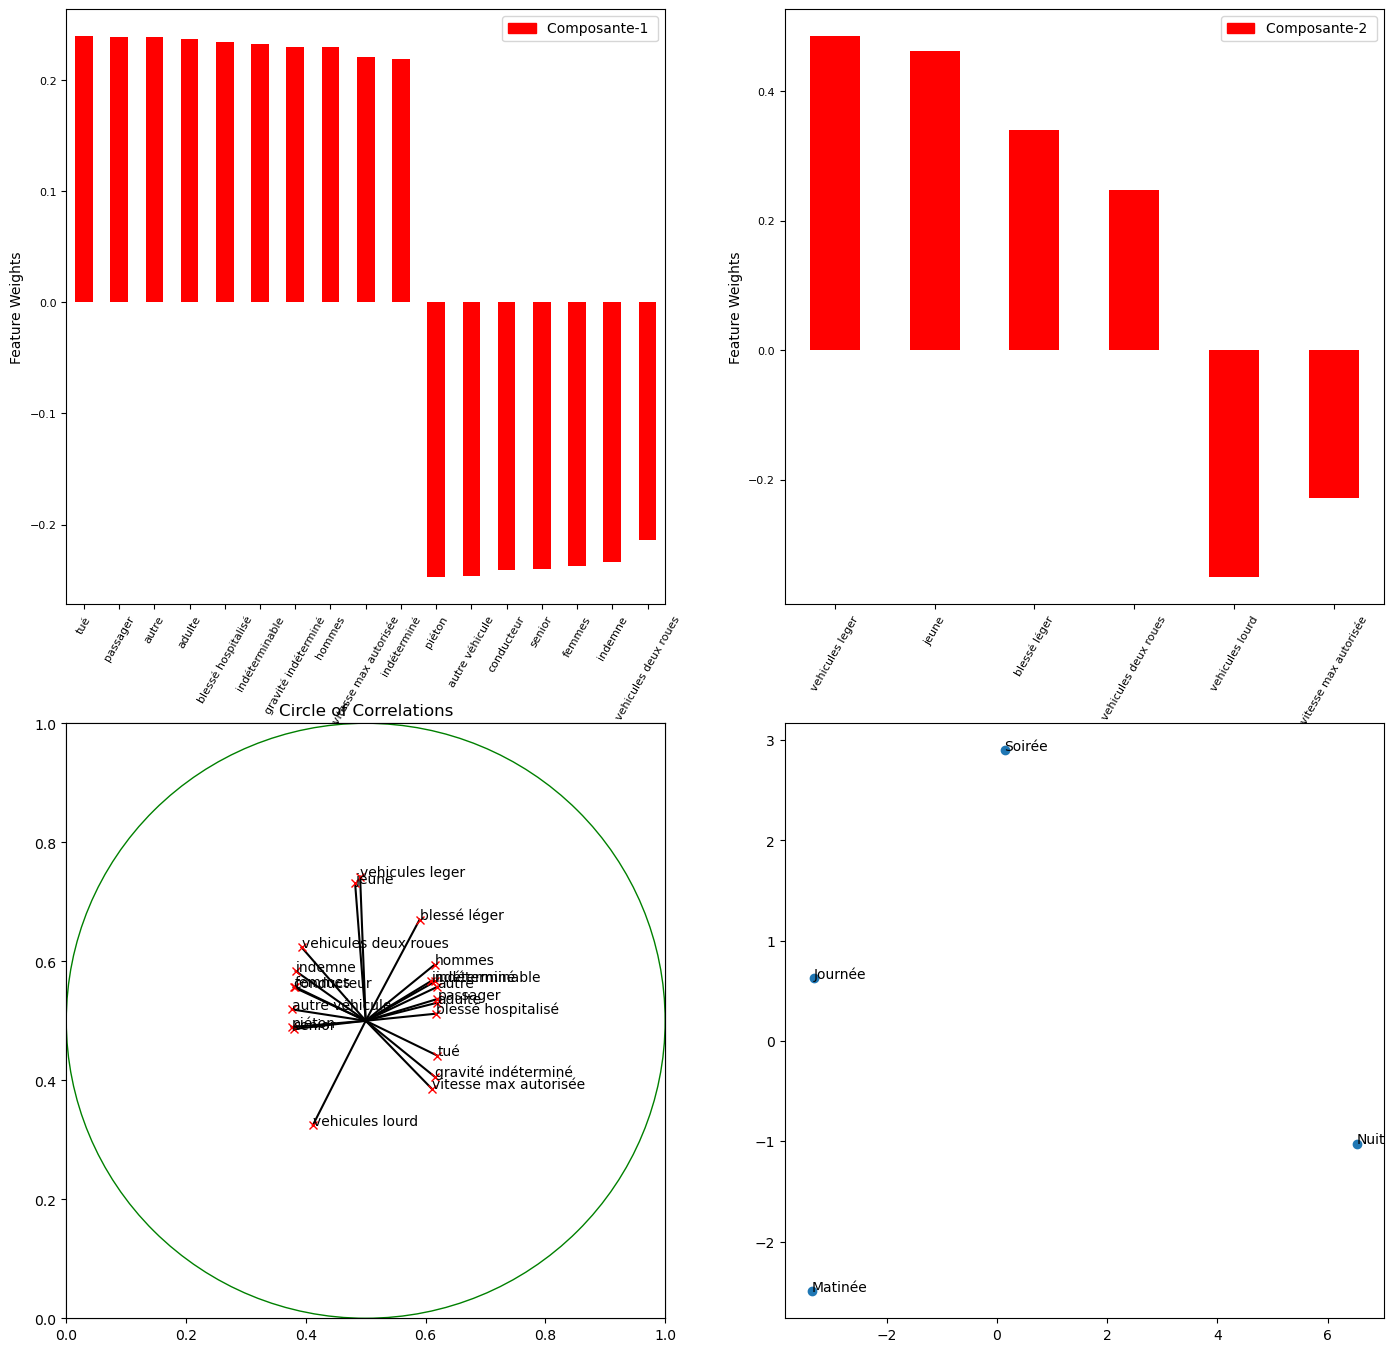

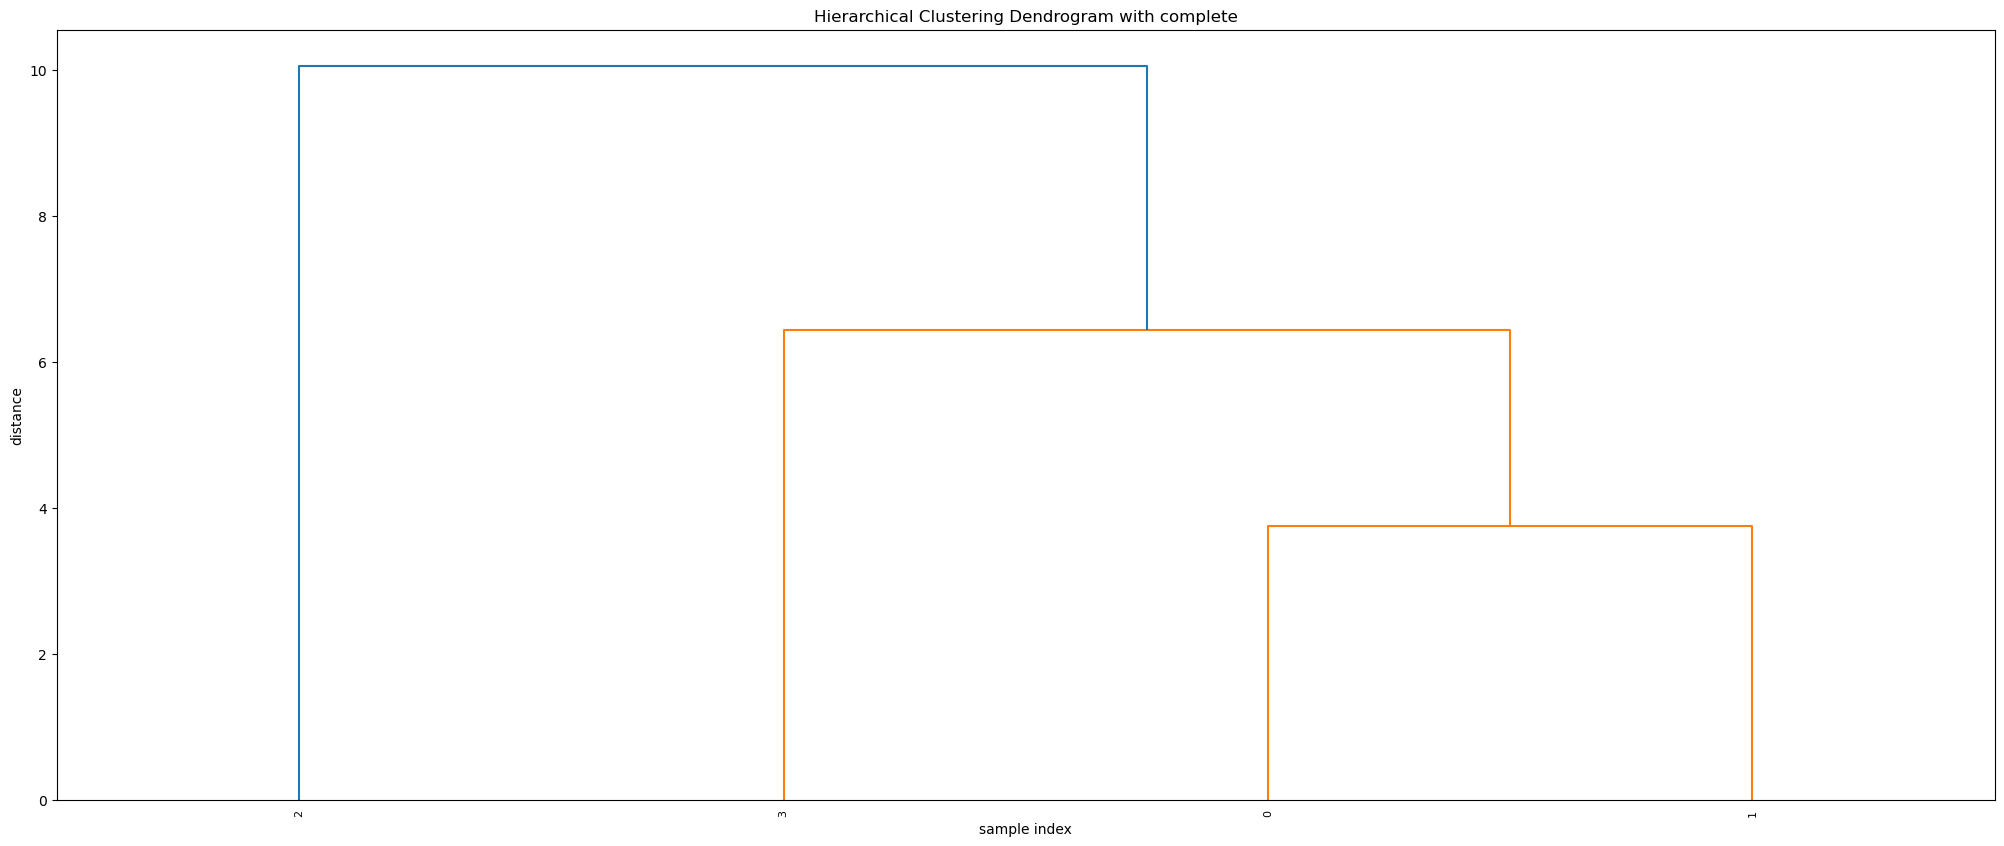

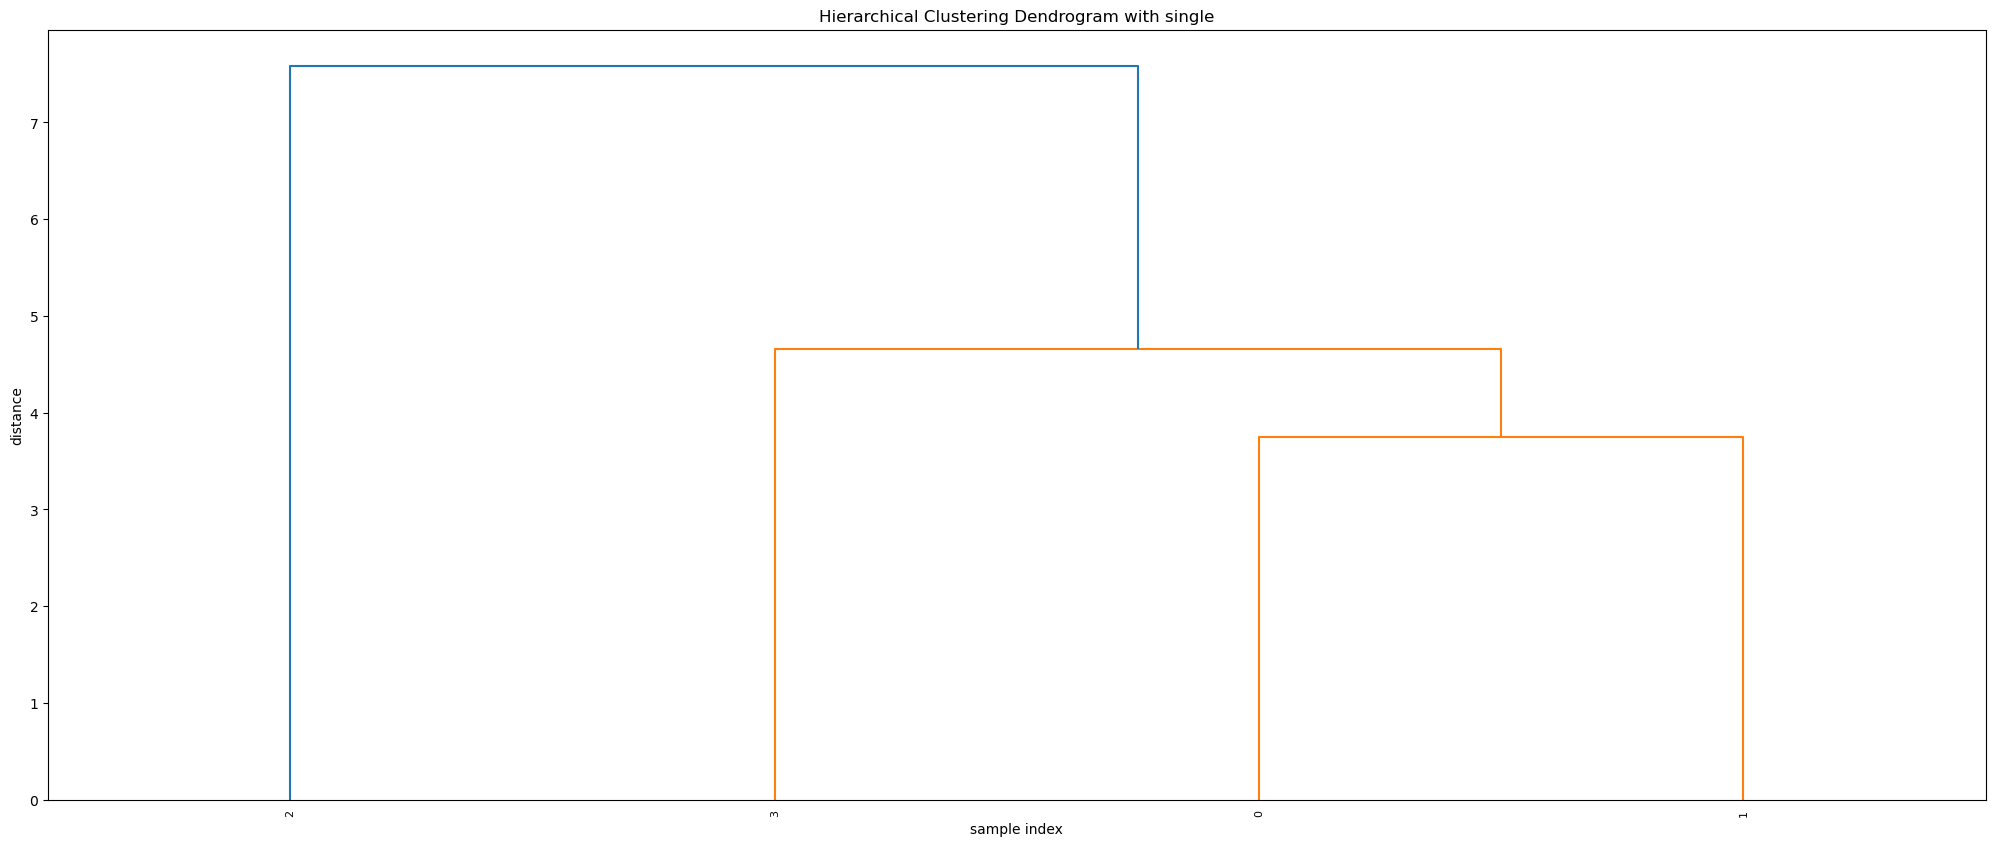

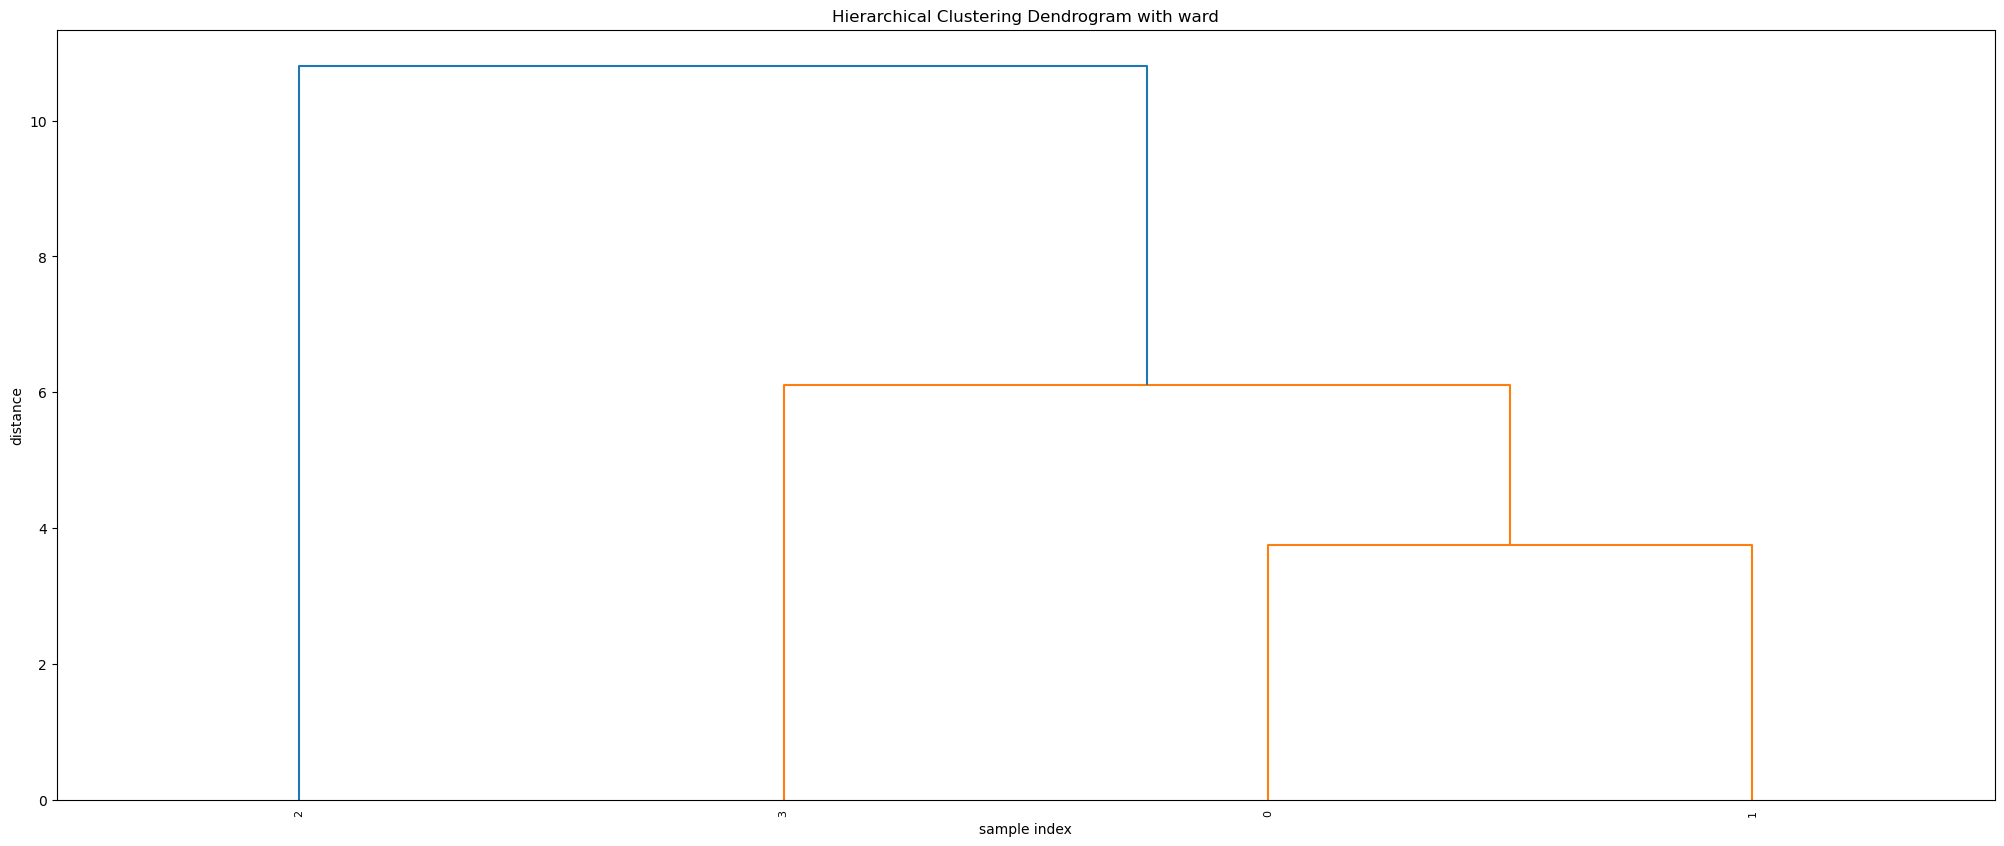

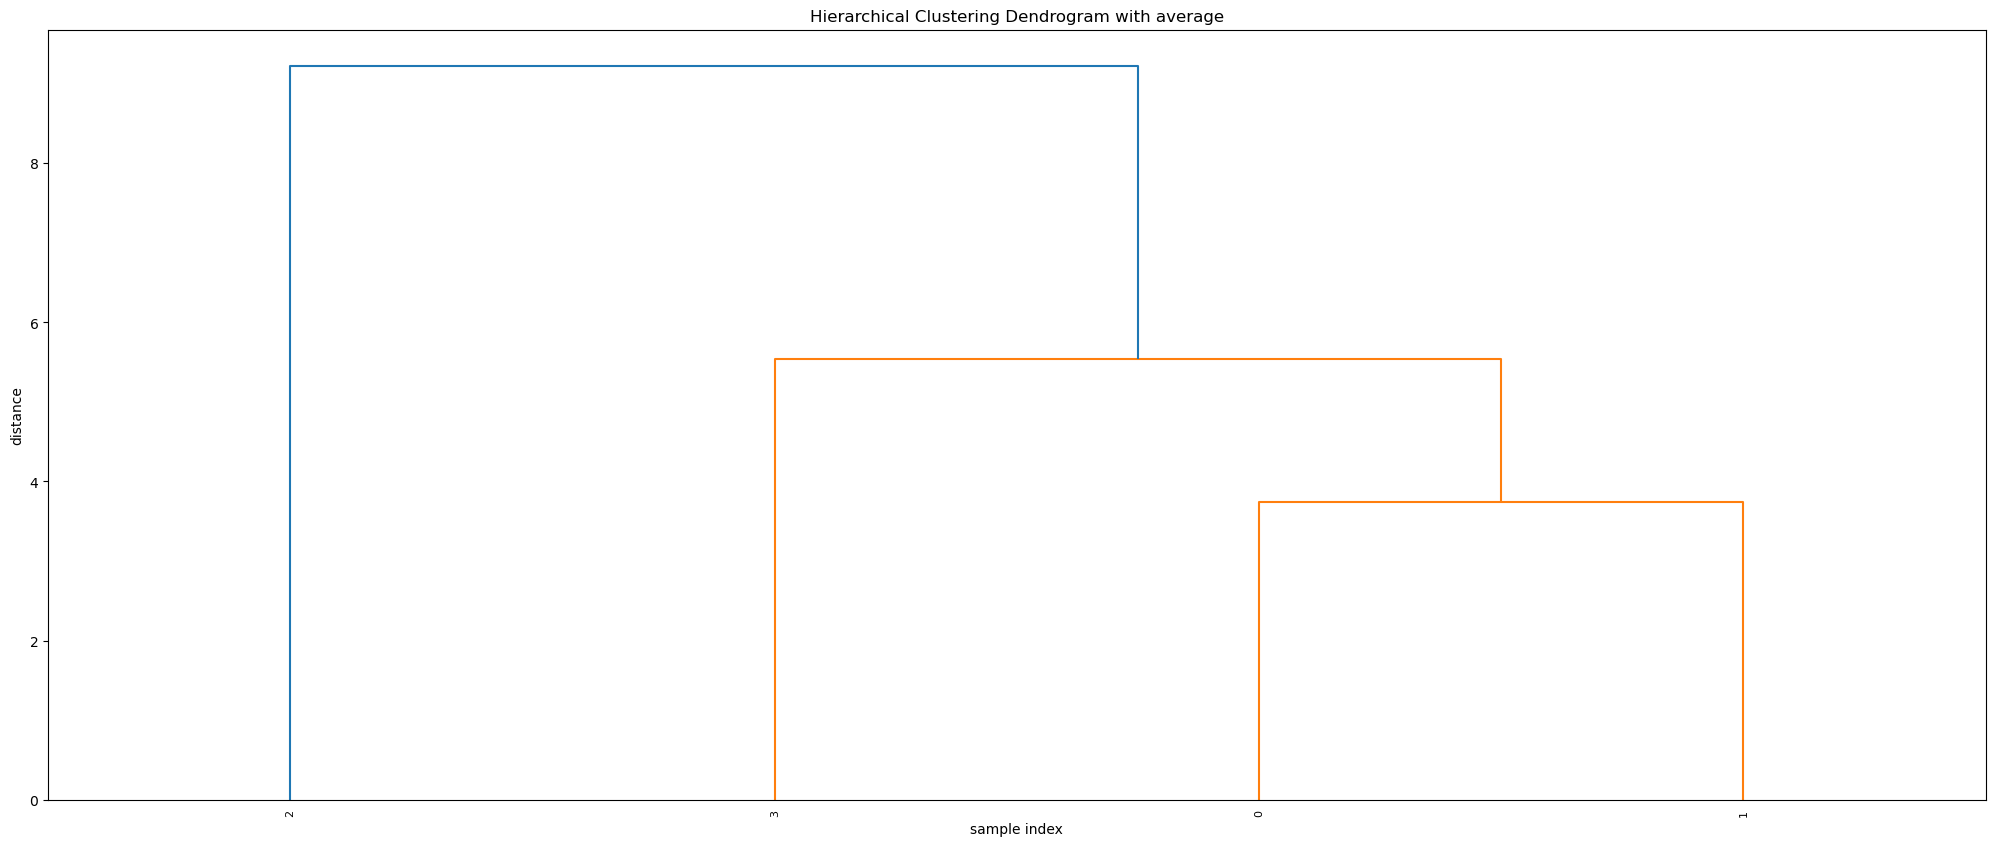

Le meilleur nombre de cluster est 2


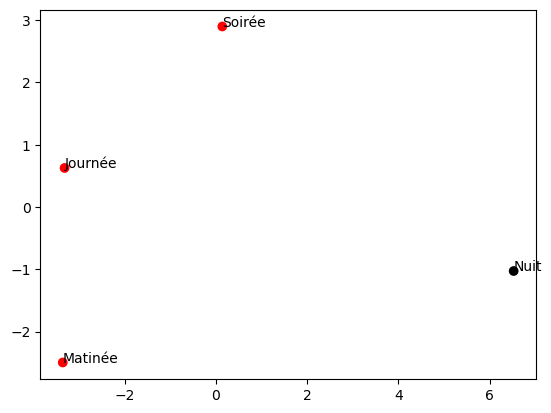

La méthode utilisé pour le CAH est ward
Le meilleur nombre de cluster est 2


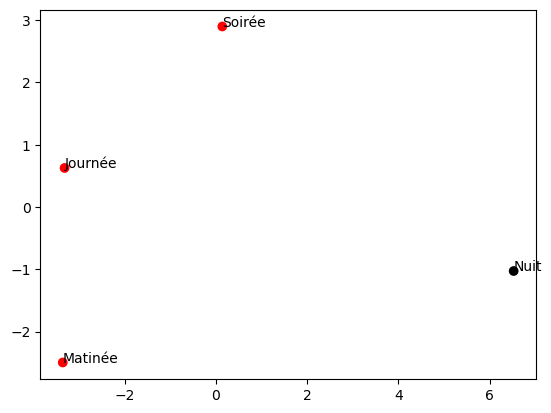

La méthode utilisé pour le CAH est average
Le meilleur nombre de cluster est 2


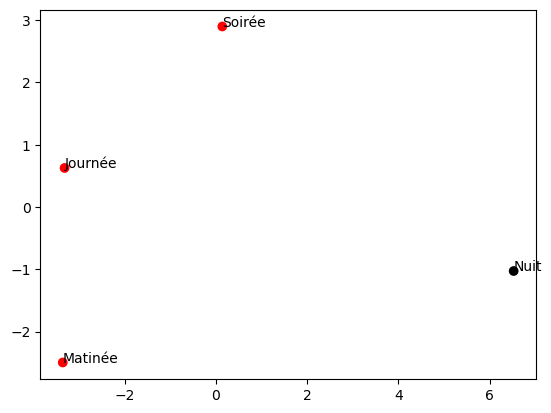

In [15]:
visualize_data("horraire")

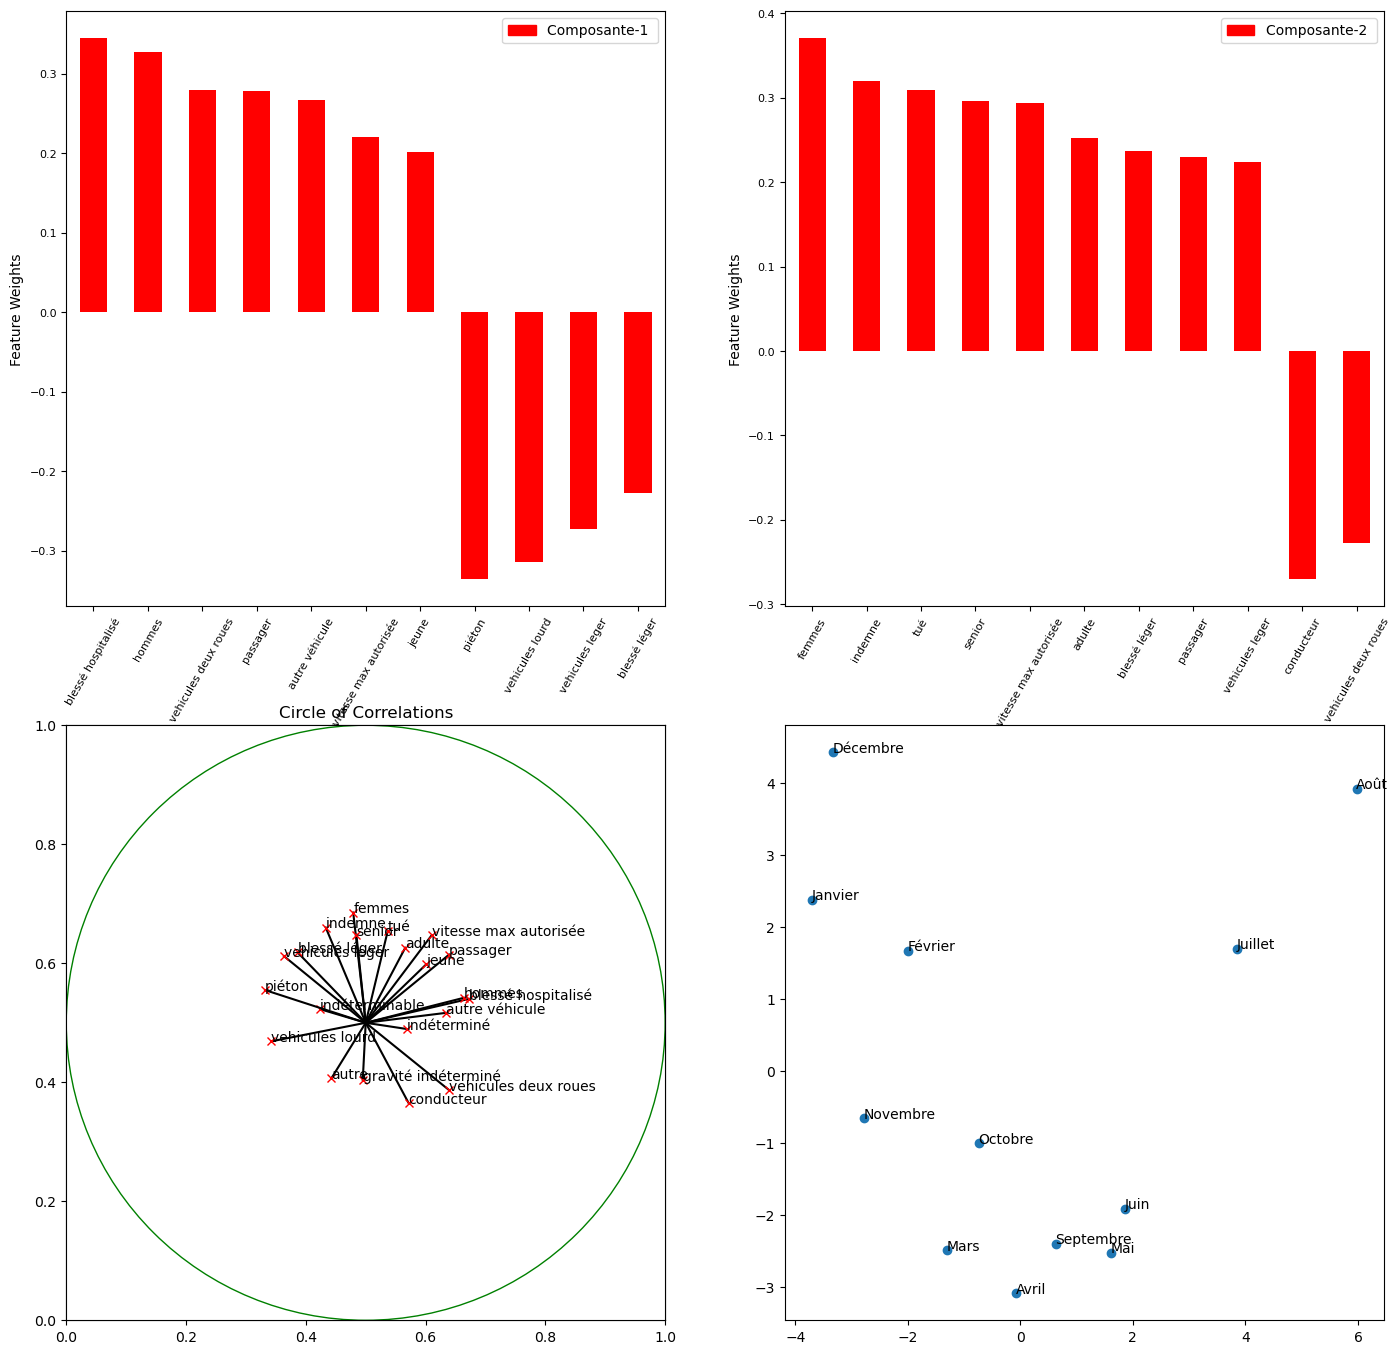

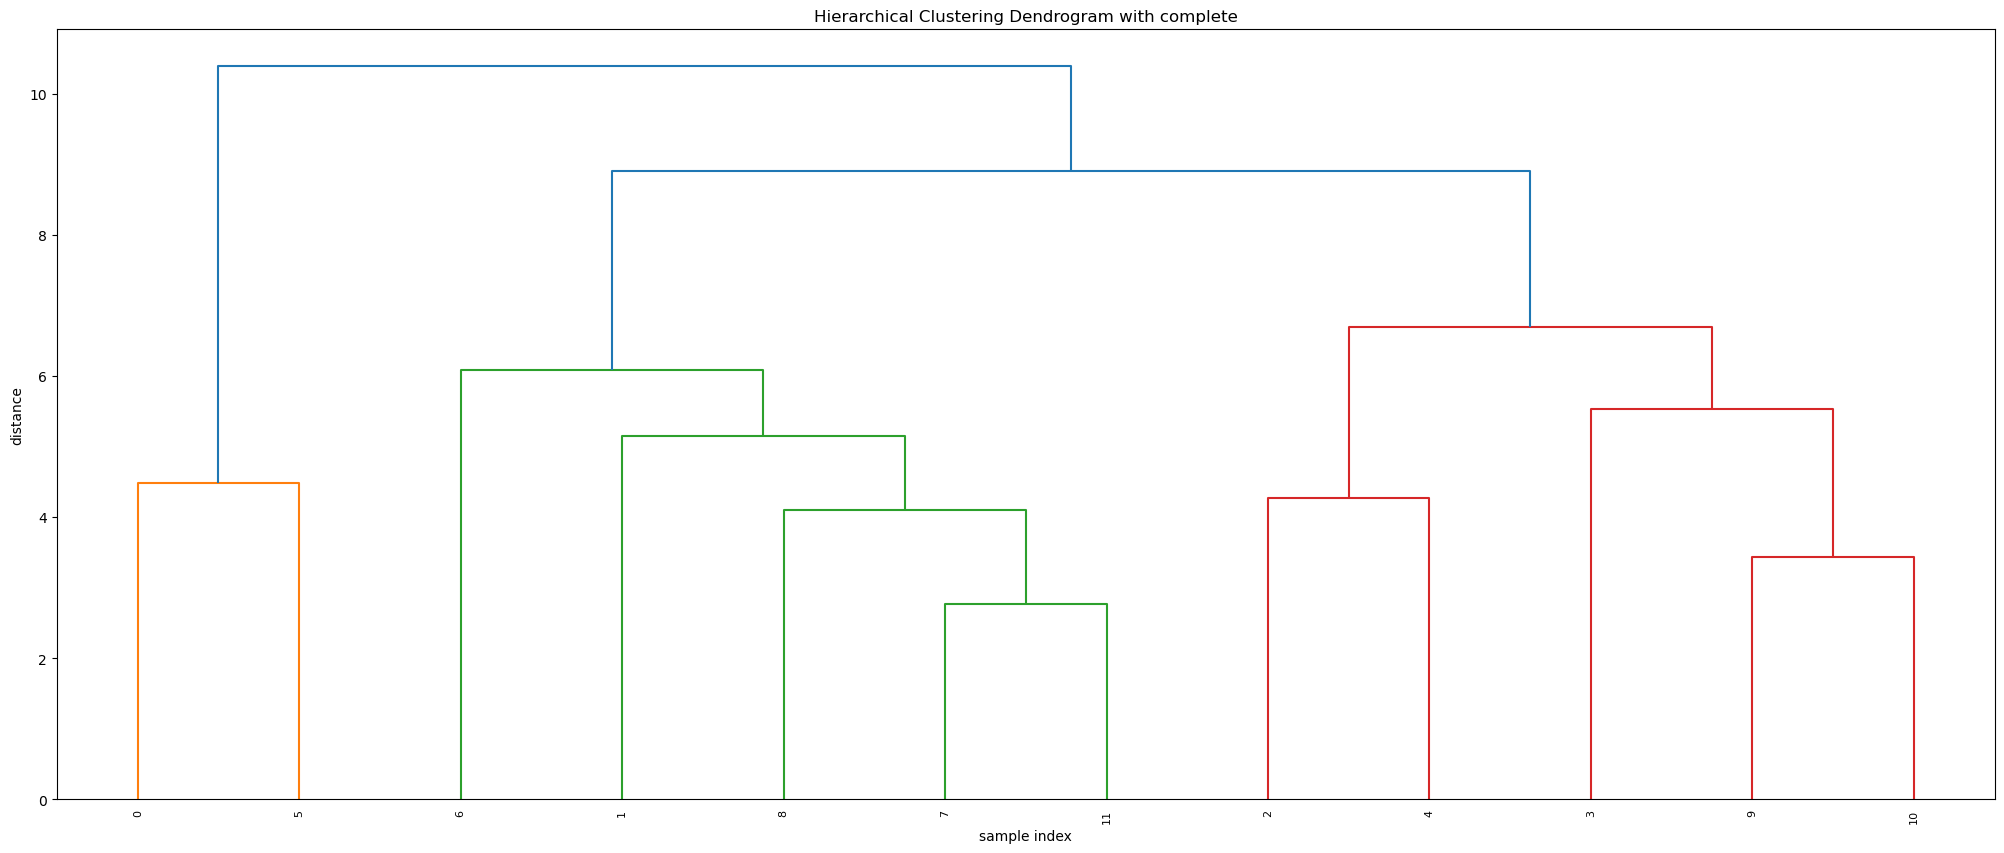

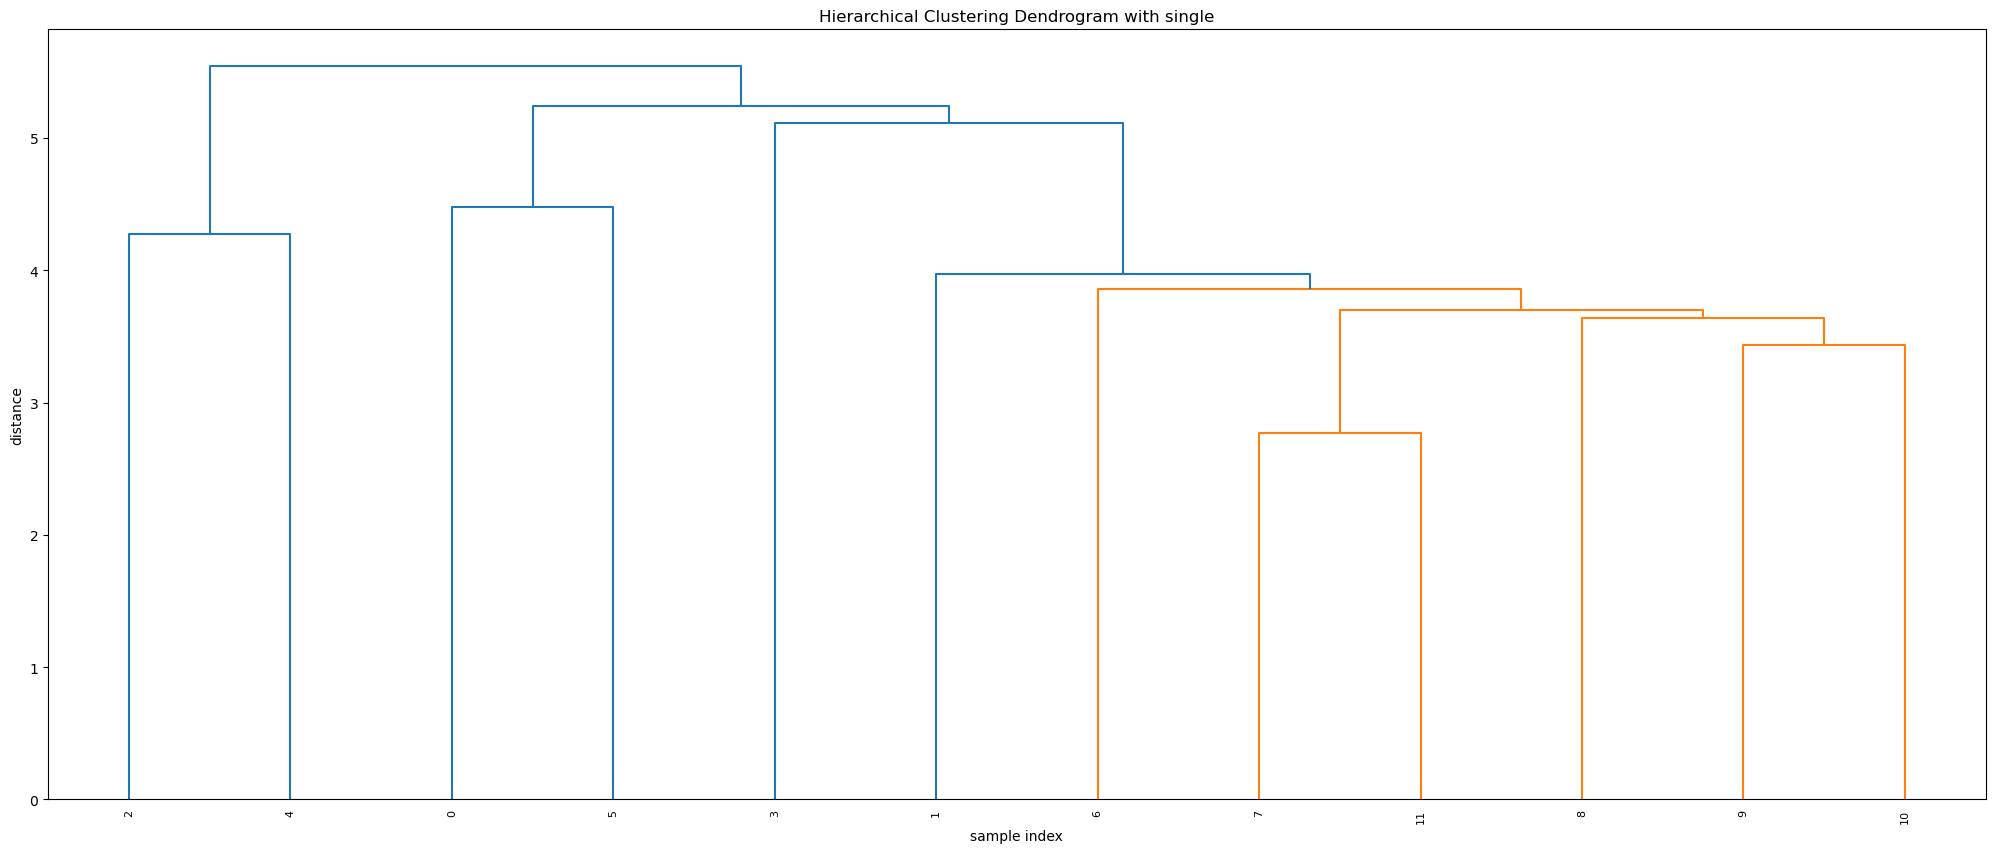

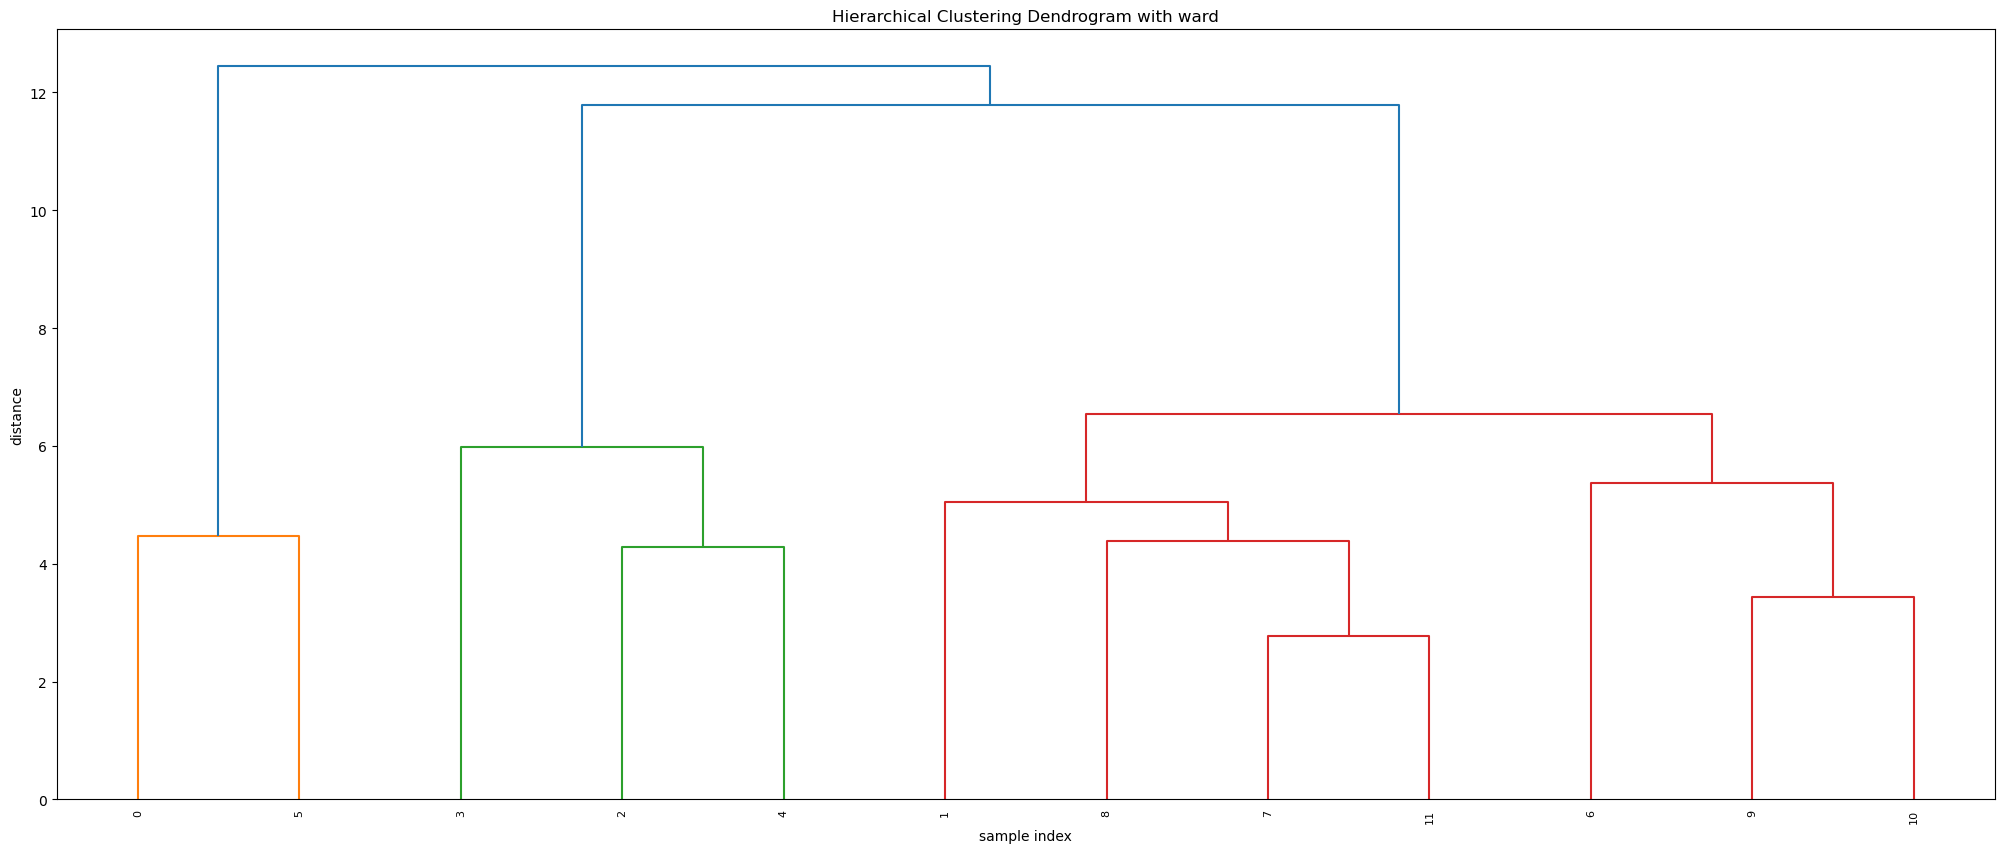

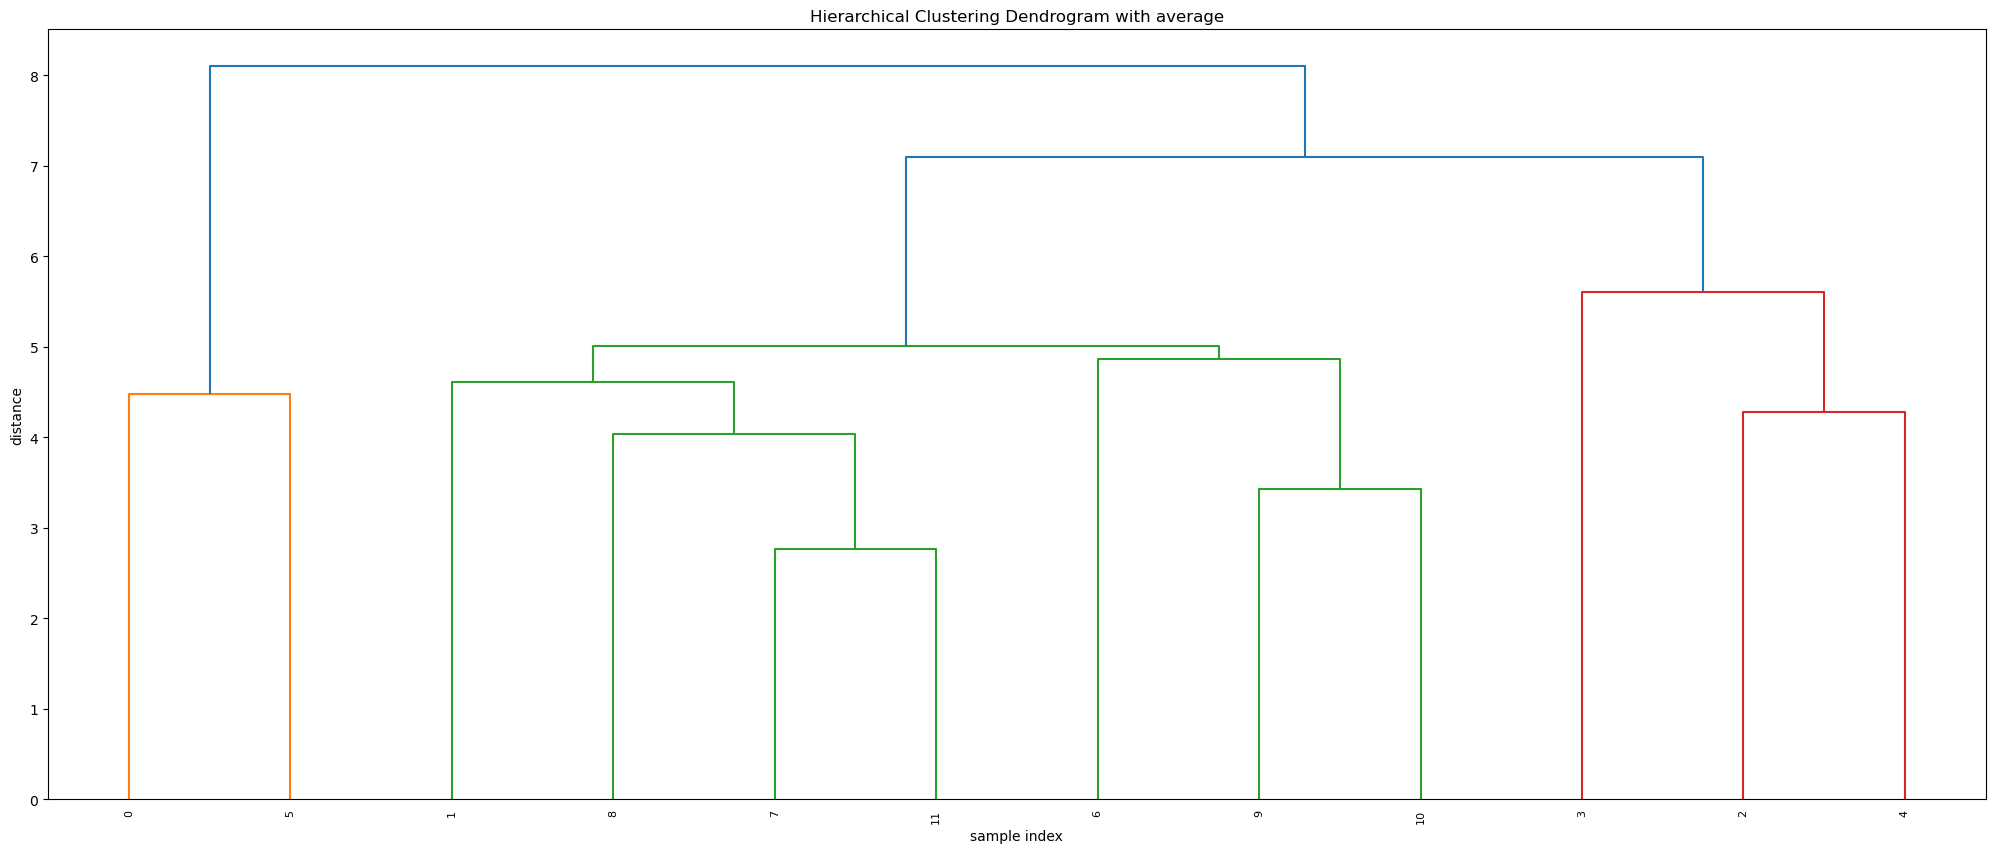

Le meilleur nombre de cluster est 3


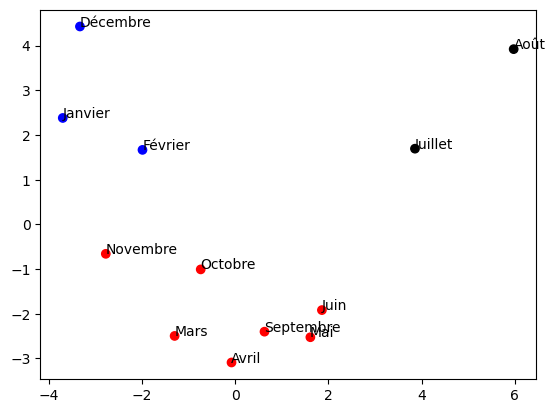

La méthode utilisé pour le CAH est ward
Le meilleur nombre de cluster est 3


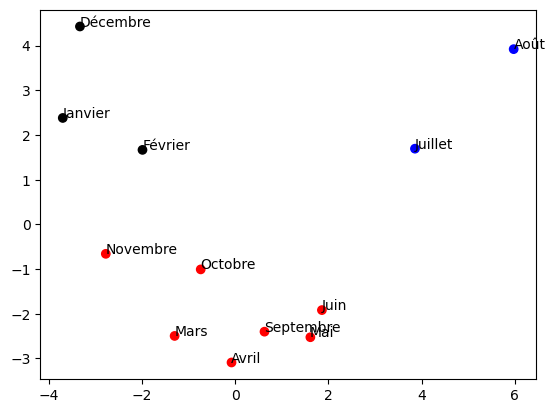

La méthode utilisé pour le CAH est average
Le meilleur nombre de cluster est 3


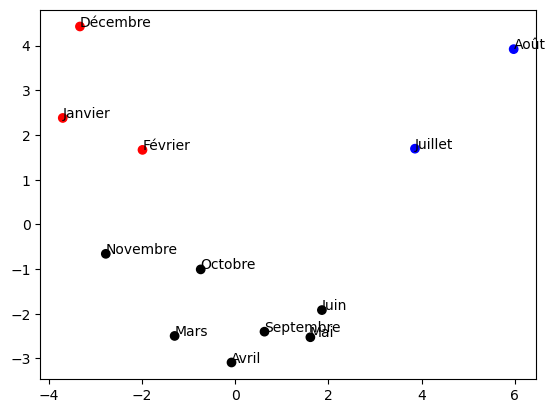

In [16]:
visualize_data("mois")

# Arbre de décision

In [17]:
pd.set_option('display.max_rows', None)
DFapprentissage = caracteristiques


In [18]:
DFapprentissage = pd.get_dummies(DFapprentissage,columns=['atmosphere','intersection','agglomération','etat de la surface','infrastructure','vitesse max autorisée','vehicules deux roues','vehicules leger','vehicules lourd','régime de circulation'])

In [19]:
X = caracteristiques.iloc[:,17:]
Y = caracteristiques.loc[:, caracteristiques.columns == 'horraire']

In [20]:
nbN=np.count_nonzero(Y=="Nuit")/len(Y)
nbJ=np.count_nonzero(Y=="Journée")/len(Y)
nbS=np.count_nonzero(Y=="Soirée")/len(Y)
nbM=np.count_nonzero(Y=="Matinée")/len(Y)
print('Nuit {0:.3f}, Journée {1:.3f}, Soirée {2:.3f}, Matinée {3:.3f}'.format(nbN,nbJ,nbS,nbM))

Nuit 0.082, Journée 0.432, Soirée 0.270, Matinée 0.217


# Découpage en apprentissage et test

In [21]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,ConfusionMatrixDisplay

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.3,shuffle=True,stratify=Y,random_state=1)

# Choix des paramètres de l'arbre

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
parametres_DT={'criterion':('gini','entropy'),
              'max_depth' : (3,4,5,6,7,10,None)}
DT=DecisionTreeClassifier(random_state=1)
GS=GridSearchCV(DT,parametres_DT,cv=10,scoring='accuracy')
GS.fit(Xtrain,Ytrain)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': (3, 4, 5, 6, 7, 10, None)},
             scoring='accuracy')

In [26]:
GS.best_params_

{'criterion': 'entropy', 'max_depth': 10}

# Aprentissage

In [27]:
DT_gini=DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=10)
DT_gini.fit(Xtrain,Ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1)

Confusion Matrix:
[[23820   575   318  3561]
 [11652   522   264  1768]
 [ 2446    97   613  2216]
 [12886   321   525  3938]]
Accuracy: 44.097
Precision for each class: [0.46886072 0.34455446 0.35639535 0.34294174]
Weighted Precision: 0.399


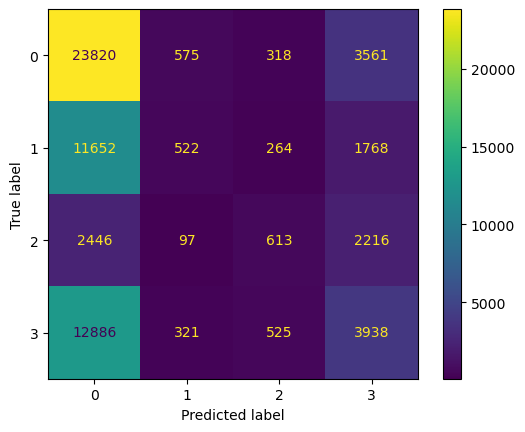

In [28]:
# Assuming Ytest and Ypred are your true labels and predicted labels, respectively
Ypred=DT_gini.predict(Xtest)
# Compute confusion matrix
cm = confusion_matrix(Ytest, Ypred)
print("Confusion Matrix:")
print(cm)

# Compute accuracy
accuracy = accuracy_score(Ytest, Ypred) * 100
print('Accuracy: {:.3f}'.format(accuracy))

# Compute precision for each class
precision = precision_score(Ytest, Ypred, average=None)
print('Precision for each class:', precision)

# If you want to compute the weighted precision (for multiclass classification)
weighted_precision = precision_score(Ytest, Ypred, average='weighted')
print('Weighted Precision: {:.3f}'.format(weighted_precision))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Motif frequent 

In [29]:
## Modification des colonnes
carac = caracteristiques
columns_to_process = ['infrastructure','nombre de voix', 'vitesse max autorisée','autre véhicule', 'vehicules deux roues', 'vehicules leger',
                       'vehicules lourd', 'hommes', 'femmes', 'jeune', 'adulte',
                       'senior', 'conducteur', 'passager', 'piéton']

for col in columns_to_process:
    carac[col] = carac[col].astype(str) + " " + col
    
carac.head(6)

,Accident_Id,jour,mois,année,horraire,luminosité,département,agglomération,intersection,atmosphere,...,blessé léger,autre,hommes,femmes,jeune,adulte,senior,conducteur,passager,piéton
0,201900000001,30,Novembre,2019,Nuit,Nuit avec éclairage public non allumé,Seine-Saint-Denis,Hors agglomération,Hors intersection,Normale,...,2,0,1 hommes,2 femmes,1 jeune,1 adulte,1 senior,2 conducteur,1 passager,0 piéton
1,201900000002,30,Novembre,2019,Nuit,Nuit sans éclairage public,Seine-Saint-Denis,Hors agglomération,Hors intersection,Normale,...,1,0,0 hommes,1 femmes,0 jeune,1 adulte,0 senior,1 conducteur,0 passager,0 piéton
2,201900000003,28,Novembre,2019,Journée,Plein jour,Hauts-de-Seine,Hors agglomération,Hors intersection,Normale,...,2,0,3 hommes,1 femmes,0 jeune,3 adulte,1 senior,3 conducteur,1 passager,0 piéton
3,201900000004,30,Novembre,2019,Soirée,Nuit avec éclairage public allumé,Val-de-Marne,Hors agglomération,Hors intersection,Normale,...,1,0,3 hommes,1 femmes,0 jeune,4 adulte,0 senior,3 conducteur,1 passager,0 piéton
4,201900000005,30,Novembre,2019,Nuit,Nuit sans éclairage public,Val-de-Marne,Hors agglomération,Hors intersection,Normale,...,1,0,3 hommes,0 femmes,0 jeune,3 adulte,0 senior,2 conducteur,1 passager,0 piéton
5,201900000006,28,Novembre,2019,Journée,Plein jour,Haute-Vienne,Hors agglomération,Intersection en T,Pluie légère,...,1,0,1 hommes,1 femmes,0 jeune,1 adulte,1 senior,2 conducteur,0 passager,0 piéton


In [30]:
transactions = []

for _, row in carac.iterrows():
    transactions.append([row['mois'],row['horraire'], row['luminosité'], row['département'],
                         row['collision'], row['catégorie de route'],
                         row['régime de circulation'], row['nombre de voix'],
                         row['infrastructure'], (row['vitesse max autorisée']),
                         row['autre véhicule'],(row['vehicules deux roues']), (row['vehicules leger']),(row['vehicules lourd']),
                         (row['hommes']), (row['femmes']), (row['jeune']), (row['adulte']),
                         (row['senior']), (row['conducteur']), (row['passager']), (row['piéton'])])
transactions


[['Novembre',
  'Nuit',
  'Nuit avec éclairage public non allumé',
  'Seine-Saint-Denis',
  'Deux véhicules – par l’arrière',
  'Autoroute',
  'A chaussées séparées',
  '10 nombre de voix',
  'Pont -autopont infrastructure',
  '70 vitesse max autorisée',
  '0 autre véhicule',
  '0 vehicules deux roues',
  '1 vehicules leger',
  '1 vehicules lourd',
  '1 hommes',
  '2 femmes',
  '1 jeune',
  '1 adulte',
  '1 senior',
  '2 conducteur',
  '1 passager',
  '0 piéton'],
 ['Novembre',
  'Nuit',
  'Nuit sans éclairage public',
  'Seine-Saint-Denis',
  'Autre collision',
  'Autoroute',
  'A sens unique',
  '2 nombre de voix',
  'Aucun infrastructure',
  '70 vitesse max autorisée',
  '0 autre véhicule',
  '0 vehicules deux roues',
  '1 vehicules leger',
  '0 vehicules lourd',
  '0 hommes',
  '1 femmes',
  '0 jeune',
  '1 adulte',
  '0 senior',
  '1 conducteur',
  '0 passager',
  '0 piéton'],
 ['Novembre',
  'Journée',
  'Plein jour',
  'Hauts-de-Seine',
  'Trois véhicules et plus – en chaîne',

In [31]:
# Forcer toutes les valeurs à être des chaînes
transactions = [[str(item) for item in transaction] for transaction in transactions]

# Utilisez TransactionEncoder pour encoder nos données
te = TransactionEncoder()
data = te.fit(transactions).transform(transactions)
print(data)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [32]:
train = pd.DataFrame(data, columns=te.columns_)
frequent_accident = apriori(train, min_support=0.3, use_colnames=True)

In [33]:
# Ajoutez une colonne 'length' contenant le nombre d'items dans chaque itemset
frequent_accident['length'] = frequent_accident['itemsets'].apply(lambda x: len(x))
frequent_accident

,support,itemsets,length
0,0.992505,(0 autre véhicule),1
1,0.489854,(0 femmes),1
2,0.815448,(0 jeune),1
3,0.756319,(0 passager),1
4,0.835571,(0 piéton),1
5,0.730074,(0 senior),1
6,0.567233,(0 vehicules deux roues),1
7,0.829710,(0 vehicules lourd),1
8,0.376825,(1 adulte),1
9,0.390680,(1 conducteur),1


In [34]:
# Triez le DataFrame en fonction de la colonne 'length' et du support
sorted_accident = frequent_accident.sort_values(by=['length', 'support'], ascending=[False, False]).reset_index(drop=True)

# Affichez le DataFrame trié
print(sorted_accident)

      support                                           itemsets  length
0    0.374219  (Aucun infrastructure, 0 passager, 0 piéton, 0...       6
1    0.357017  (Aucun infrastructure, 0 senior, 0 piéton, 0 a...       6
2    0.349041  (Aucun infrastructure, 0 senior, 0 passager, 0...       6
3    0.341399  (0 senior, 0 passager, 0 piéton, 0 autre véhic...       6
4    0.323964  (Aucun infrastructure, 0 senior, 0 passager, 0...       6
5    0.323195  (Aucun infrastructure, 0 senior, 0 passager, 0...       6
6    0.316208  (Aucun infrastructure, 0 piéton, 0 autre véhic...       6
7    0.309990  (Aucun infrastructure, 0 passager, 0 piéton, 0...       6
8    0.308145  (Aucun infrastructure, 0 piéton, 0 autre véhic...       6
9    0.307856  (Aucun infrastructure, 0 piéton, 0 autre véhic...       6
10   0.303364  (Aucun infrastructure, 0 passager, 0 autre véh...       6
11   0.302527  (Aucun infrastructure, 0 piéton, 0 autre véhic...       6
12   0.473448  (Aucun infrastructure, 0 piéton, 0 a

In [35]:
print( "Affichage du permier motif aprés trie: ", sorted_accident.itemsets[10])

Affichage du permier motif aprés trie:  frozenset({'Aucun infrastructure', '0 passager', '0 autre véhicule', 'Plein jour', '0 vehicules lourd', '0 jeune'})
